# Combining it all - Alternative CV technique

This notebook is the same as the previous, but for the zref and density cross validation, we use a different technique. Instead of switch to a regional estimation technique which doesn't use the constraint points, we instead keep using the constraint point minimization regional estimation technique, but split constraints into testing and training sets, performing a K-Folds cross validation to determine the optimal zref and density contrast values. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib
import pickle

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get Input datasets

In [2]:
true_topography, _, _, _ = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    # topography_coarsen_factor=2,
    # topography_percent_noise=0.02,
)

# create lower synthetic topography data
lower_topography = invert4geom.synthetic_topography_regional(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    scale=1,
    yoffset=-1000,
)

true_zref = true_topography.to_numpy().mean()
true_density_contrast = 2670 - 1  # sea level
print(f"mean of true topography: {true_zref} m ")

mean of true topography: 492.2704164812973 m 


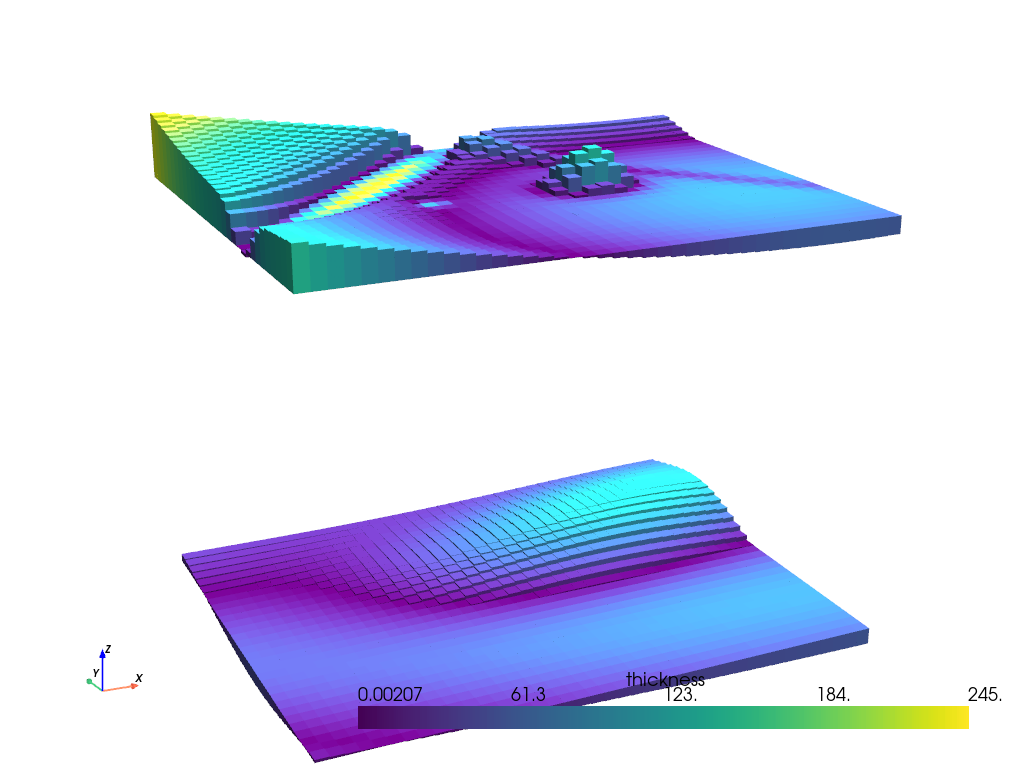

In [3]:
topography_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    starting_topography=true_topography.to_dataset(name="upward"),
)
basement_model = invert4geom.create_model(
    zref=lower_topography.to_numpy().mean(),
    density_contrast=3300 - 2800,
    starting_topography=lower_topography.to_dataset(name="upward"),
)

invert4geom.show_prism_layers(
    [topography_model, basement_model],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey

# create an inside region to reduce gravity edge effects
# region = vd.pad_region(topography_model.region, topography_model.spacing * -5)

# create lists of coordinates
coords = vd.grid_coordinates(
    region=topography_model.region,
    spacing=topography_model.spacing,
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

# grav_df = vd.grid_to_table(observations)

In [5]:
data = invert4geom.create_data(observations)

print(f"Gravity region (W,E,S,N): {data.region}")
print(f"Gravity spacing: {data.spacing} m")

data

Gravity region (W,E,S,N): (0.0, 40000.0, 0.0, 30000.0)
Gravity spacing: 1000.0 m


<xarray.Dataset> Size: 11kB
Dimensions:   (northing: 31, easting: 41)
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
Data variables:
    upward    (northing, easting) float64 10kB 1.001e+03 1.001e+03 ... 1.001e+03
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

In [6]:
data.inv.forward_gravity(topography_model, name="upper_surface_grav")
data.inv.forward_gravity(basement_model, name="lower_surface_grav")
data.inv.df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659
std,8947.792584,11836.81698,0.0,7.147140,0.830306
min,0.000000,0.00000,1001.0,-17.180401,-1.201774
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891
max,30000.000000,40000.00000,1001.0,19.581120,1.860259


In [7]:
# contaminate gravity with 0.1 mGal of random noise
data["gravity_anomaly_no_noise"] = data.upper_surface_grav + data.lower_surface_grav
data["gravity_anomaly"], stddev = invert4geom.contaminate(
    data.gravity_anomaly_no_noise,
    stddev=0.1,
    percent=False,
    seed=0,
)
data["uncert"] = xr.full_like(data.gravity_anomaly, stddev)
data

<xarray.Dataset> Size: 62kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
Data variables:
    upward                    (northing, easting) float64 10kB 1.001e+03 ... ...
    upper_surface_grav        (northing, easting) float64 10kB 9.526 ... 2.855
    lower_surface_grav        (northing, easting) float64 10kB -0.04793 ... 0...
    gravity_anomaly_no_noise  (northing, easting) float64 10kB 9.478 ... 3.368
    gravity_anomaly           (northing, easting) float64 10kB 9.495 ... 3.425
    uncert                    (northing, easting) float64 10kB 0.1 0.1 ... 0.1
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

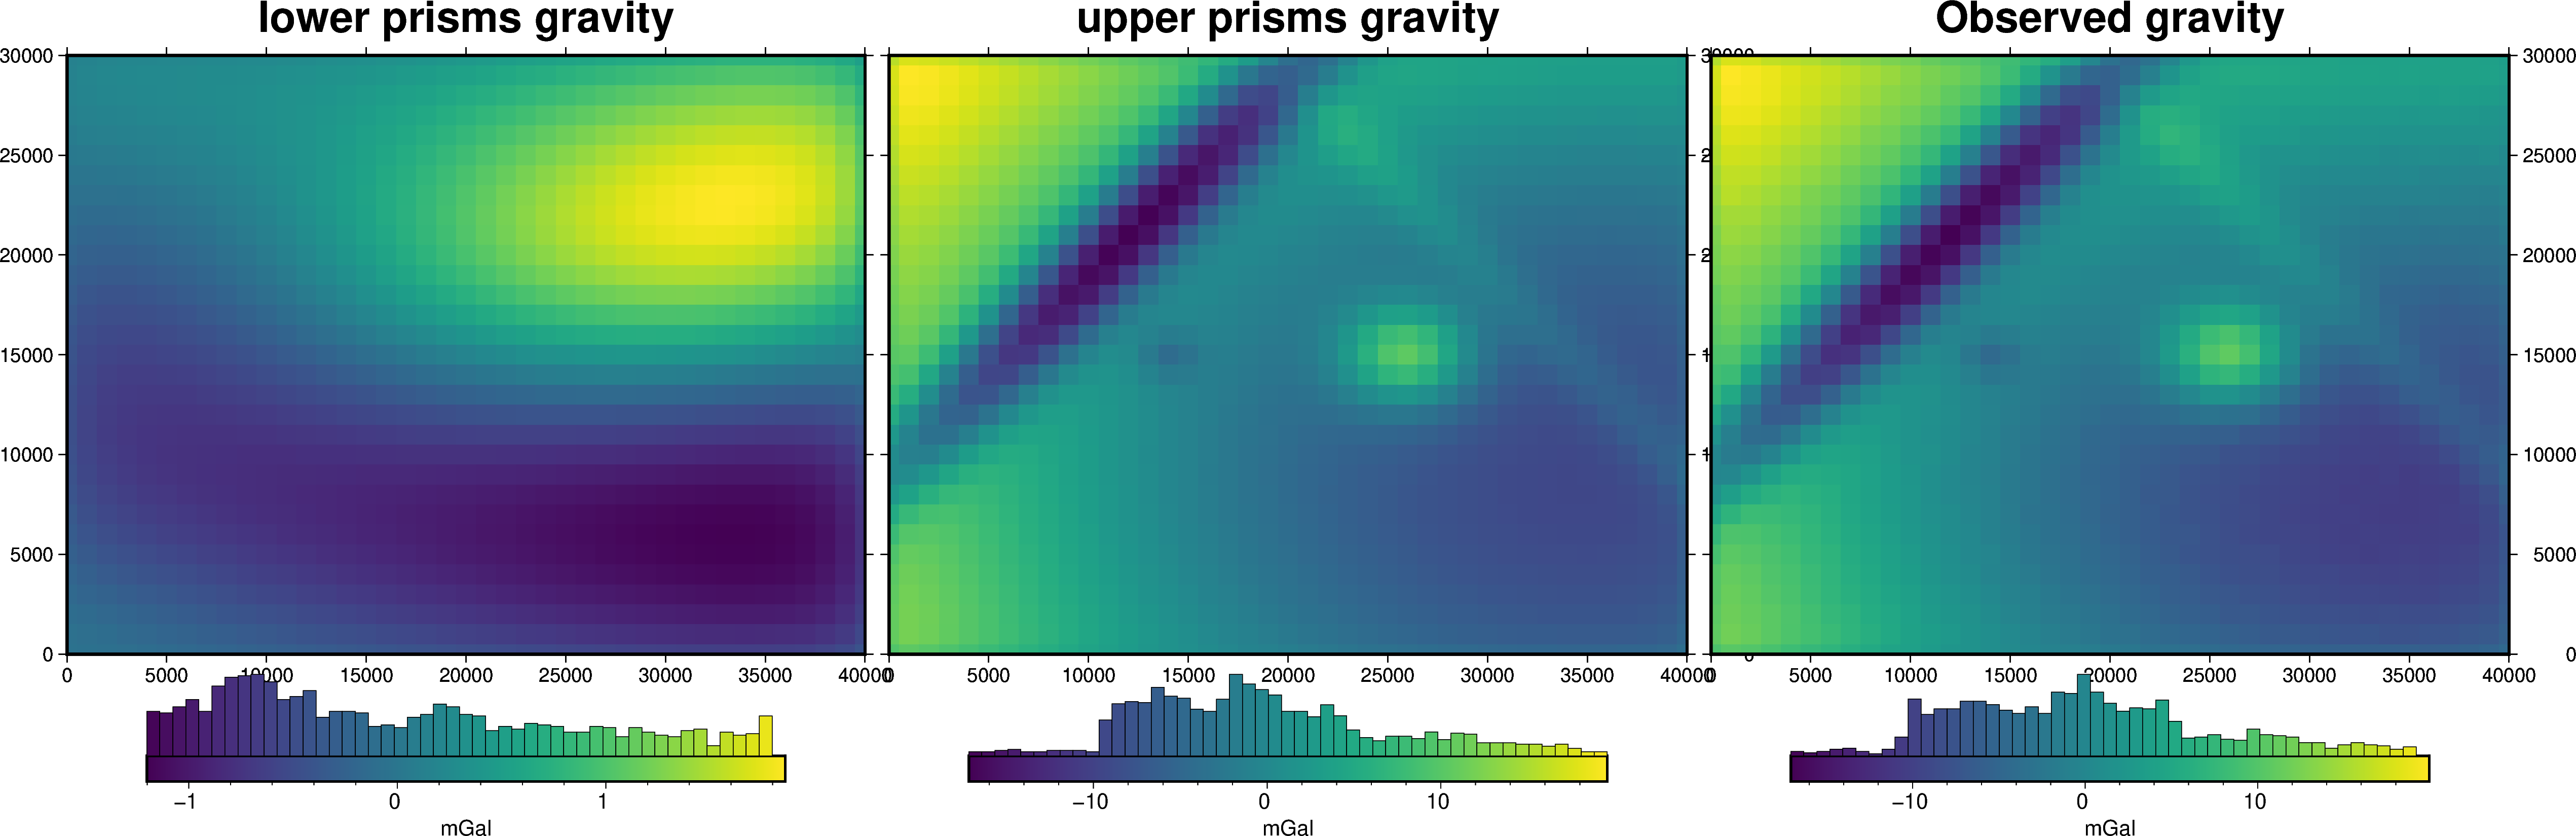

In [8]:
fig = maps.plot_grd(
    data.lower_surface_grav,
    fig_height=10,
    title="lower prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    data.upper_surface_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="upper prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    data.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Create "a-priori" topography measurements

In [9]:
# create 15 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=vd.pad_region(data.region, -data.spacing),
    size=num_constraints,
    random_state=7,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    true_topography,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = invert4geom.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

,easting,northing,true_upward,upward,uncert,weight
0,3899.714996,26468.618776,655.102400,656.749723,13.102048,0.005825
1,30636.914105,6974.789900,407.011208,405.935844,8.140224,0.015091
2,17659.550795,13659.470931,470.155613,476.177579,9.403112,0.011310
3,28491.676758,27073.768551,515.239653,516.320627,10.304793,0.009417
4,38163.601456,1697.178371,419.197817,414.706788,8.383956,0.014227


## Create starting model

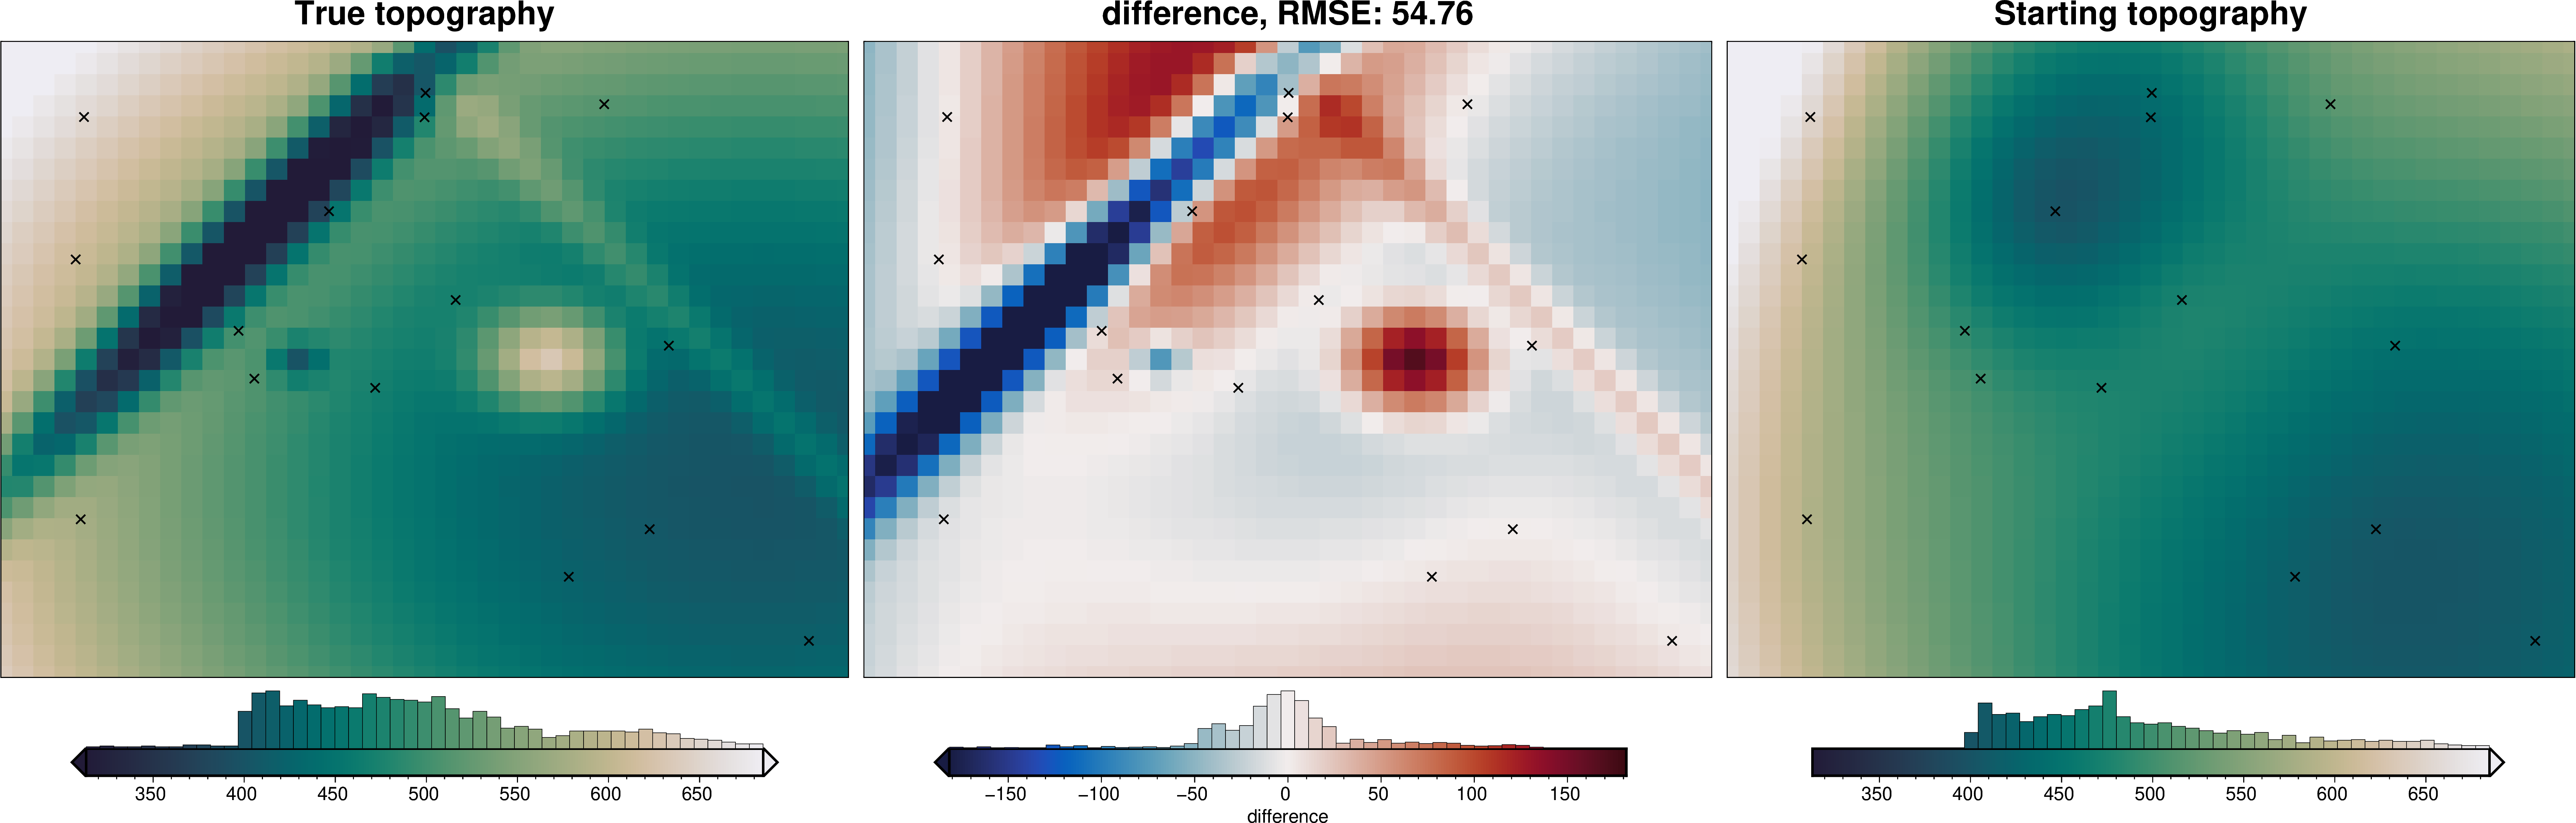

In [10]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=topography_model.region,
    spacing=topography_model.spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 100),
    weights_col="weight",
)

starting_topography = invert4geom.create_topography(
    **starting_topography_kwargs
).to_dataset(name="upward")

_ = polar_utils.grd_compare(
    true_topography,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

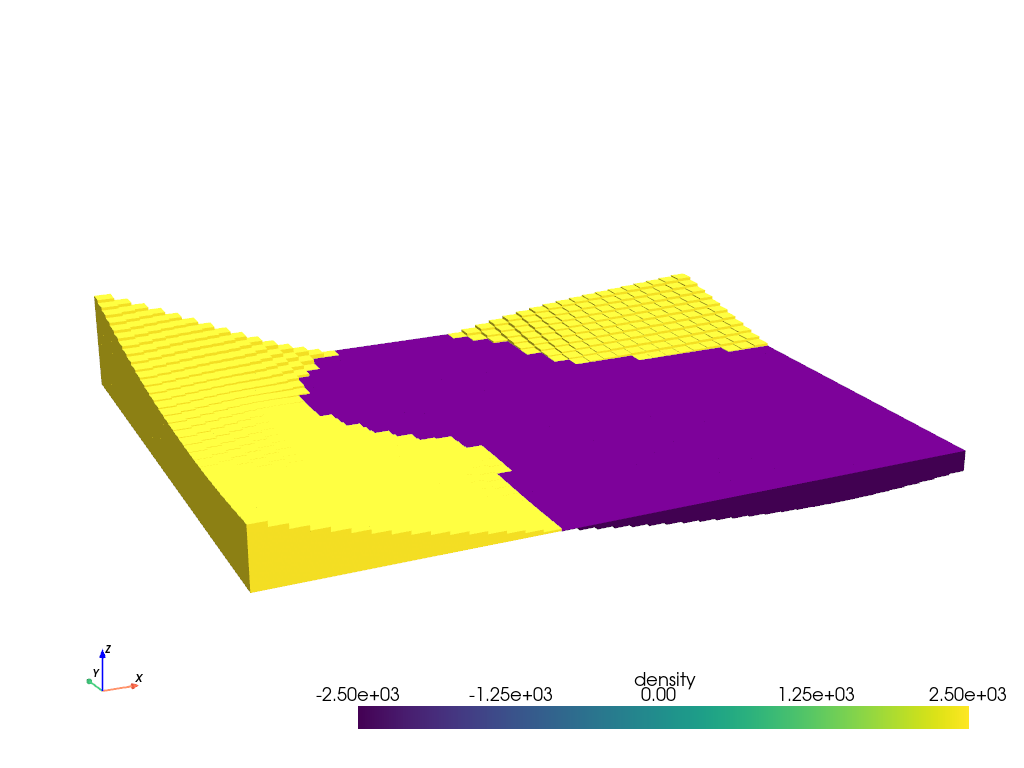

In [11]:
model = invert4geom.create_model(
    zref=constraint_points.upward.mean(),
    density_contrast=2500,
    starting_topography=starting_topography,
)
invert4geom.show_prism_layers(
    model,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropriate values for the starting model.

In [12]:
data.inv.starting_gravity(model)

# calculate the true residual misfit
# true misfit is difference between noise-free gravity and starting gravity
# true regional misfit is the moho gravity
# so true residual is misfit - true_regional
data["true_res"] = (
    data.gravity_anomaly_no_noise - data.starting_gravity - data.lower_surface_grav
)
data.inv.df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,starting_gravity,forward_gravity,true_res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659,-0.124959,-0.124959,1.000000e-01,1.079930,1.079930,-1.209548
std,8947.792584,11836.81698,0.0,7.147140,0.830306,7.314752,7.313577,2.776650e-17,6.599125,6.599125,4.456801
min,0.000000,0.00000,1001.0,-17.180401,-1.201774,-16.908338,-17.061563,1.000000e-01,-7.883841,-7.883841,-19.046853
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901,-5.826630,-5.827131,1.000000e-01,-3.944309,-3.944309,-2.622186
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953,-0.557795,-0.572175,1.000000e-01,-0.765707,-0.765707,-1.088926
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891,4.171648,4.139840,1.000000e-01,4.823461,4.823461,0.332004
max,30000.000000,40000.00000,1001.0,19.581120,1.860259,19.774399,19.944612,1.000000e-01,22.159800,22.159800,12.693226


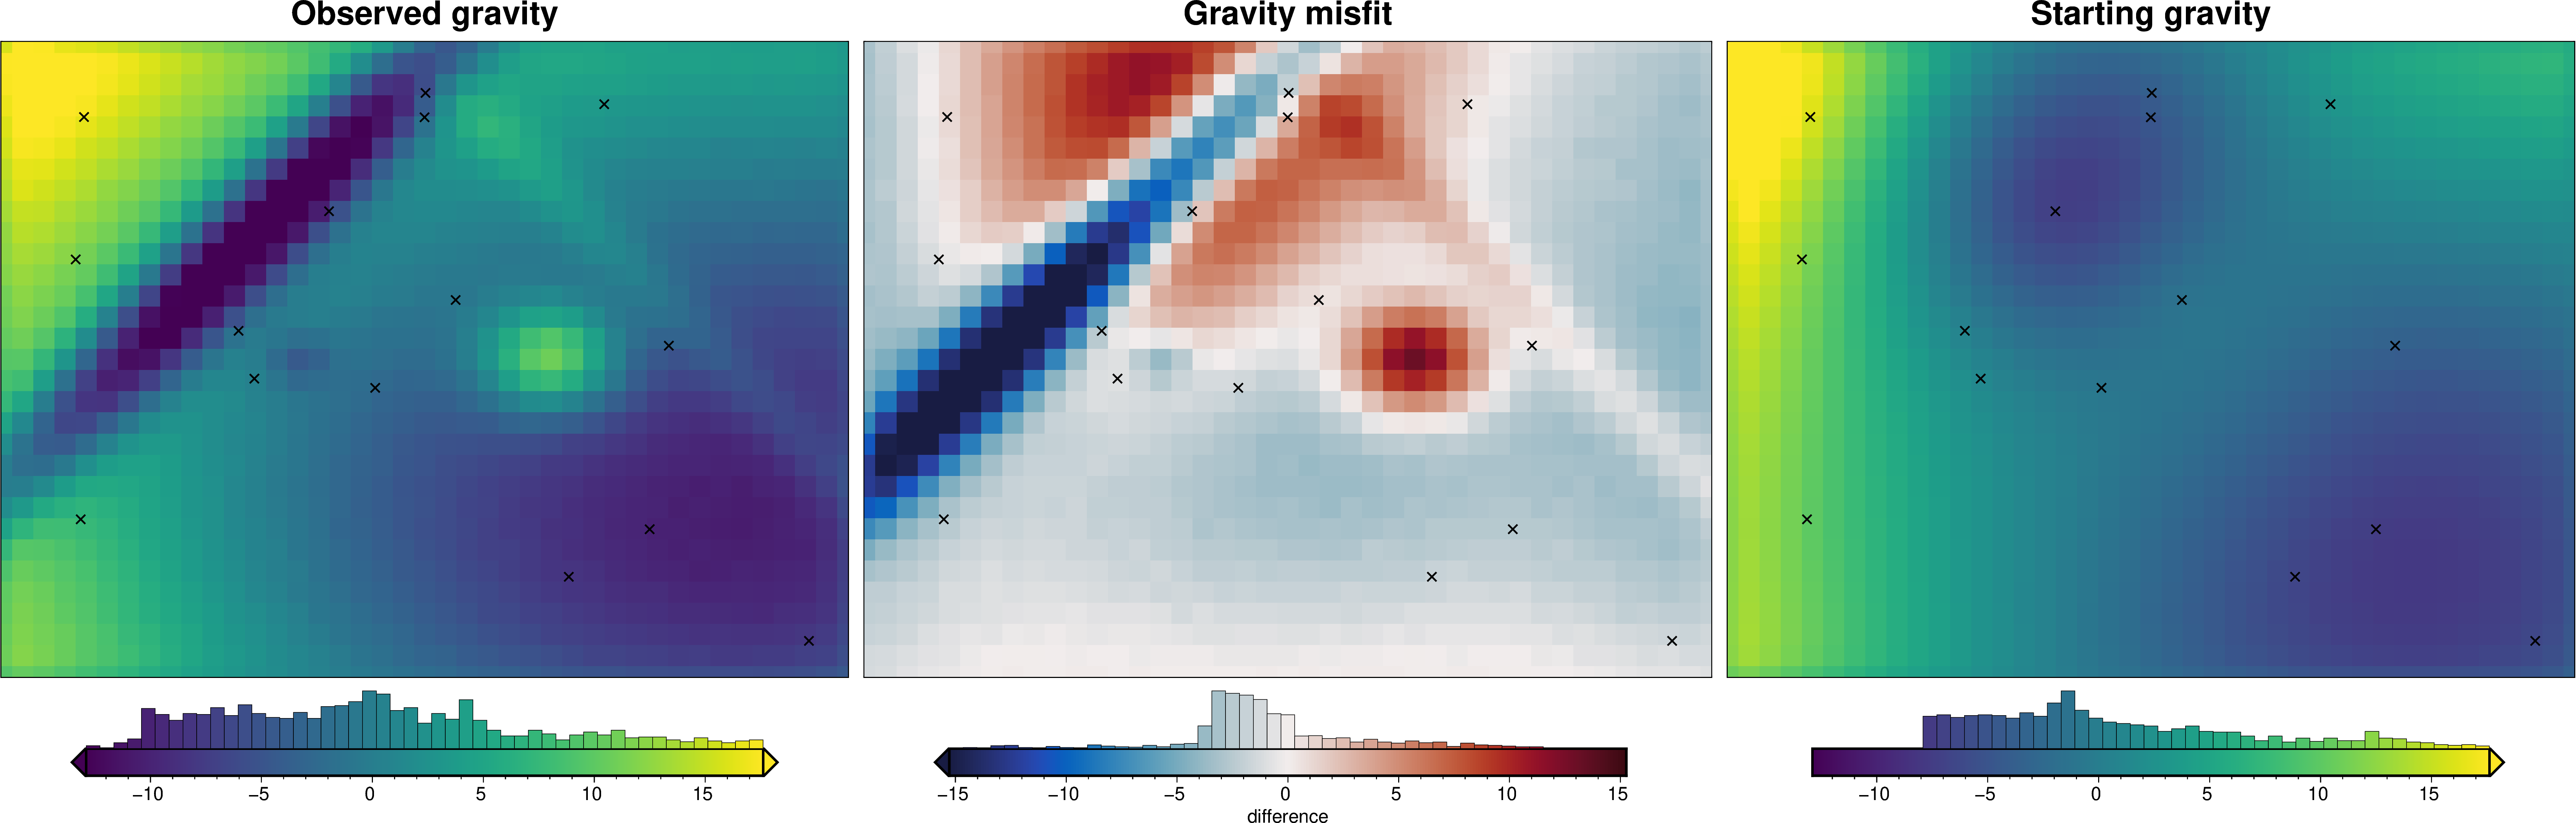

In [13]:
_ = polar_utils.grd_compare(
    data.gravity_anomaly,
    data.starting_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

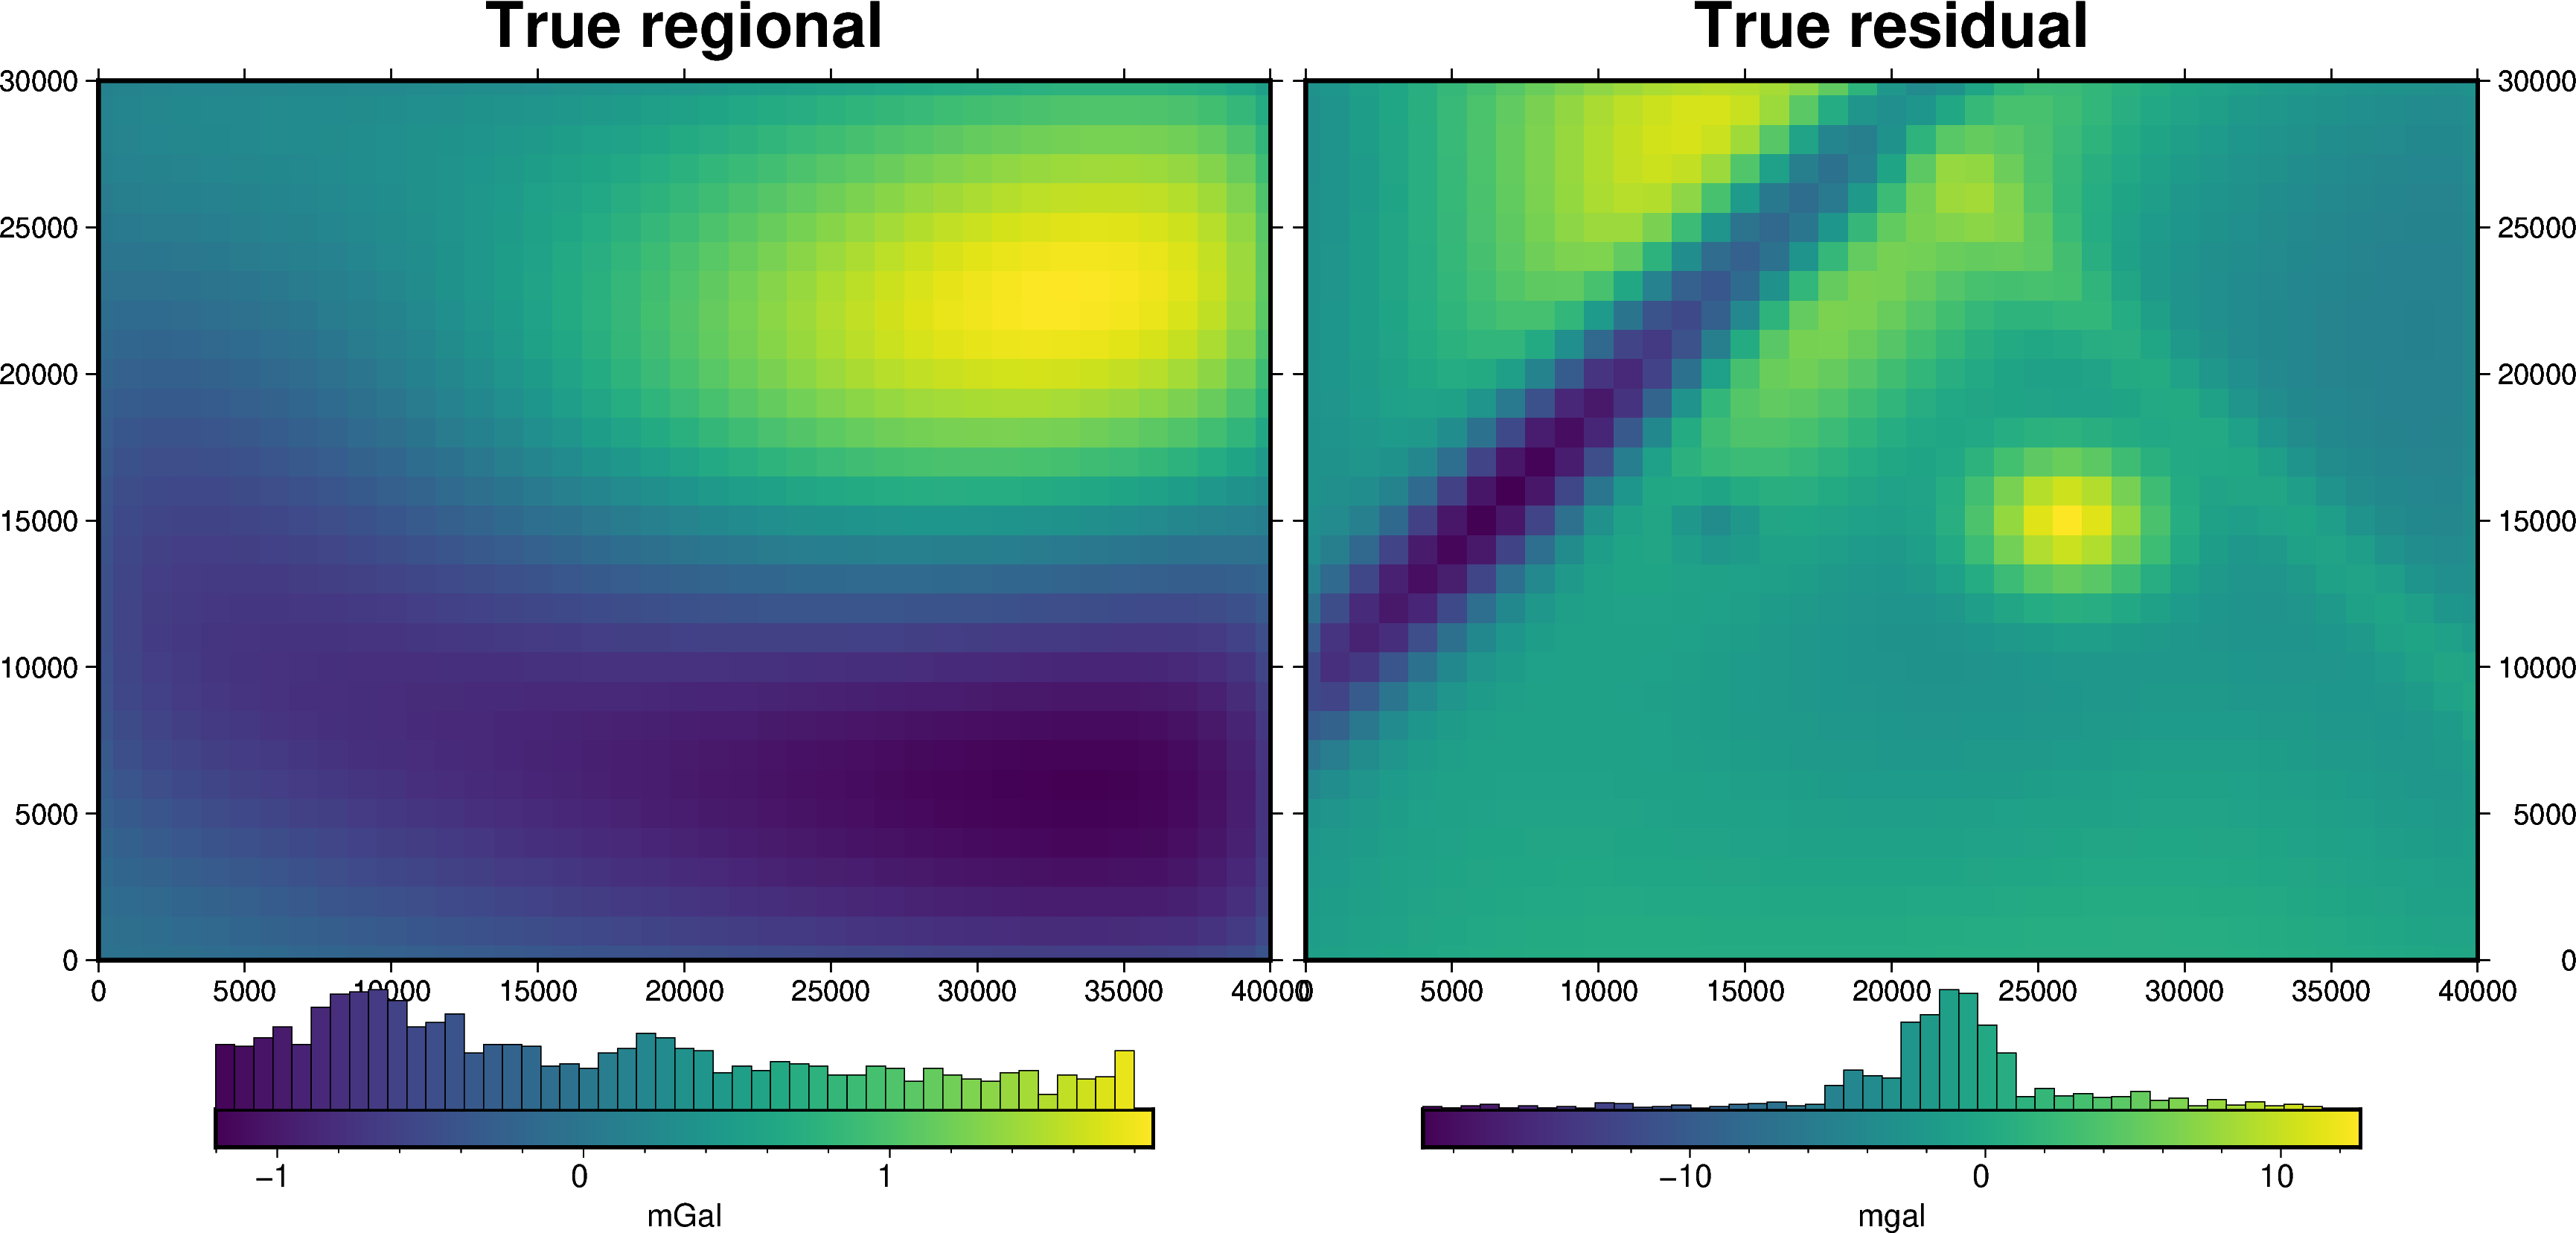

In [14]:
fig = maps.plot_grd(
    data.lower_surface_grav,
    fig_height=10,
    title="True regional",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    data.true_res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True residual",
    hist=True,
    cbar_label="mgal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Regional separation

In [15]:
def regional_comparison(data):
    # compare with true regional
    _ = polar_utils.grd_compare(
        data.lower_surface_grav,
        data.reg,
        robust=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        data.true_res,
        data.res,
        robust=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

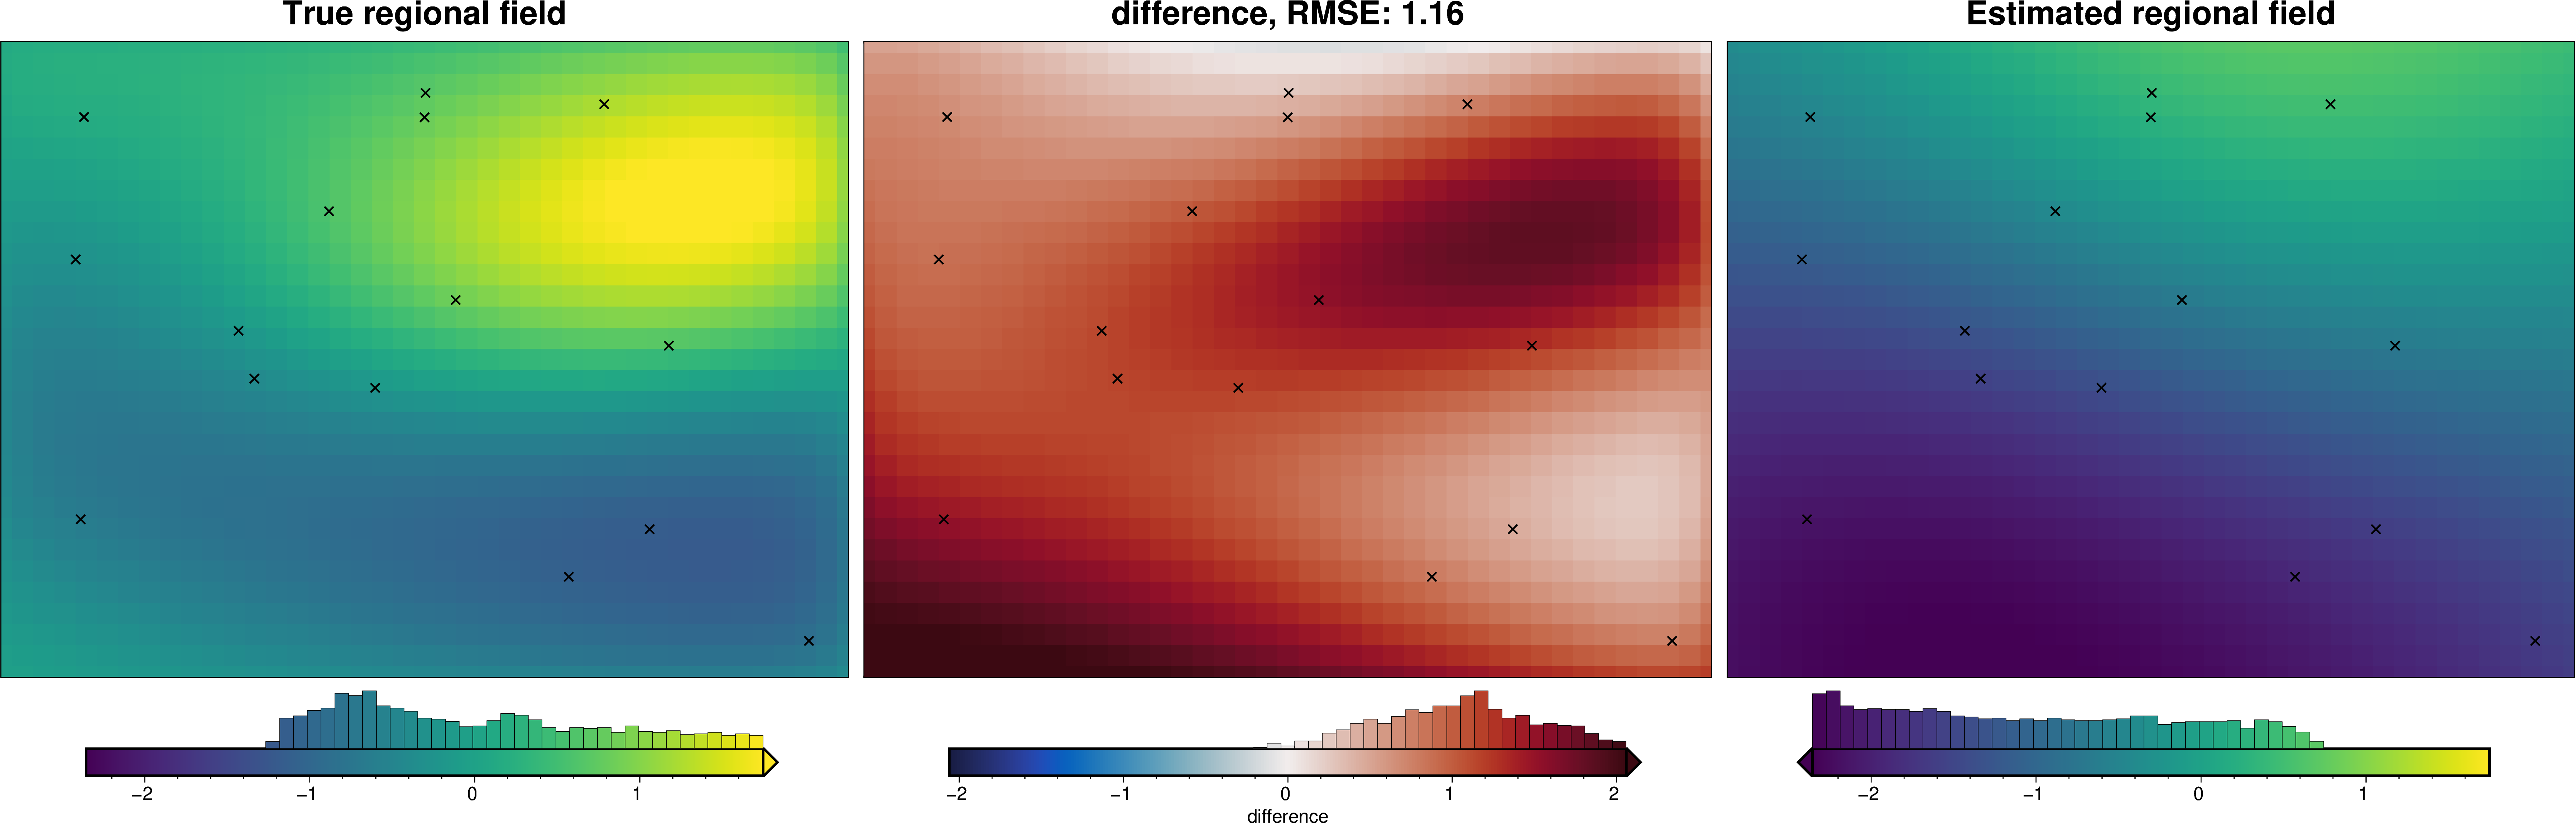

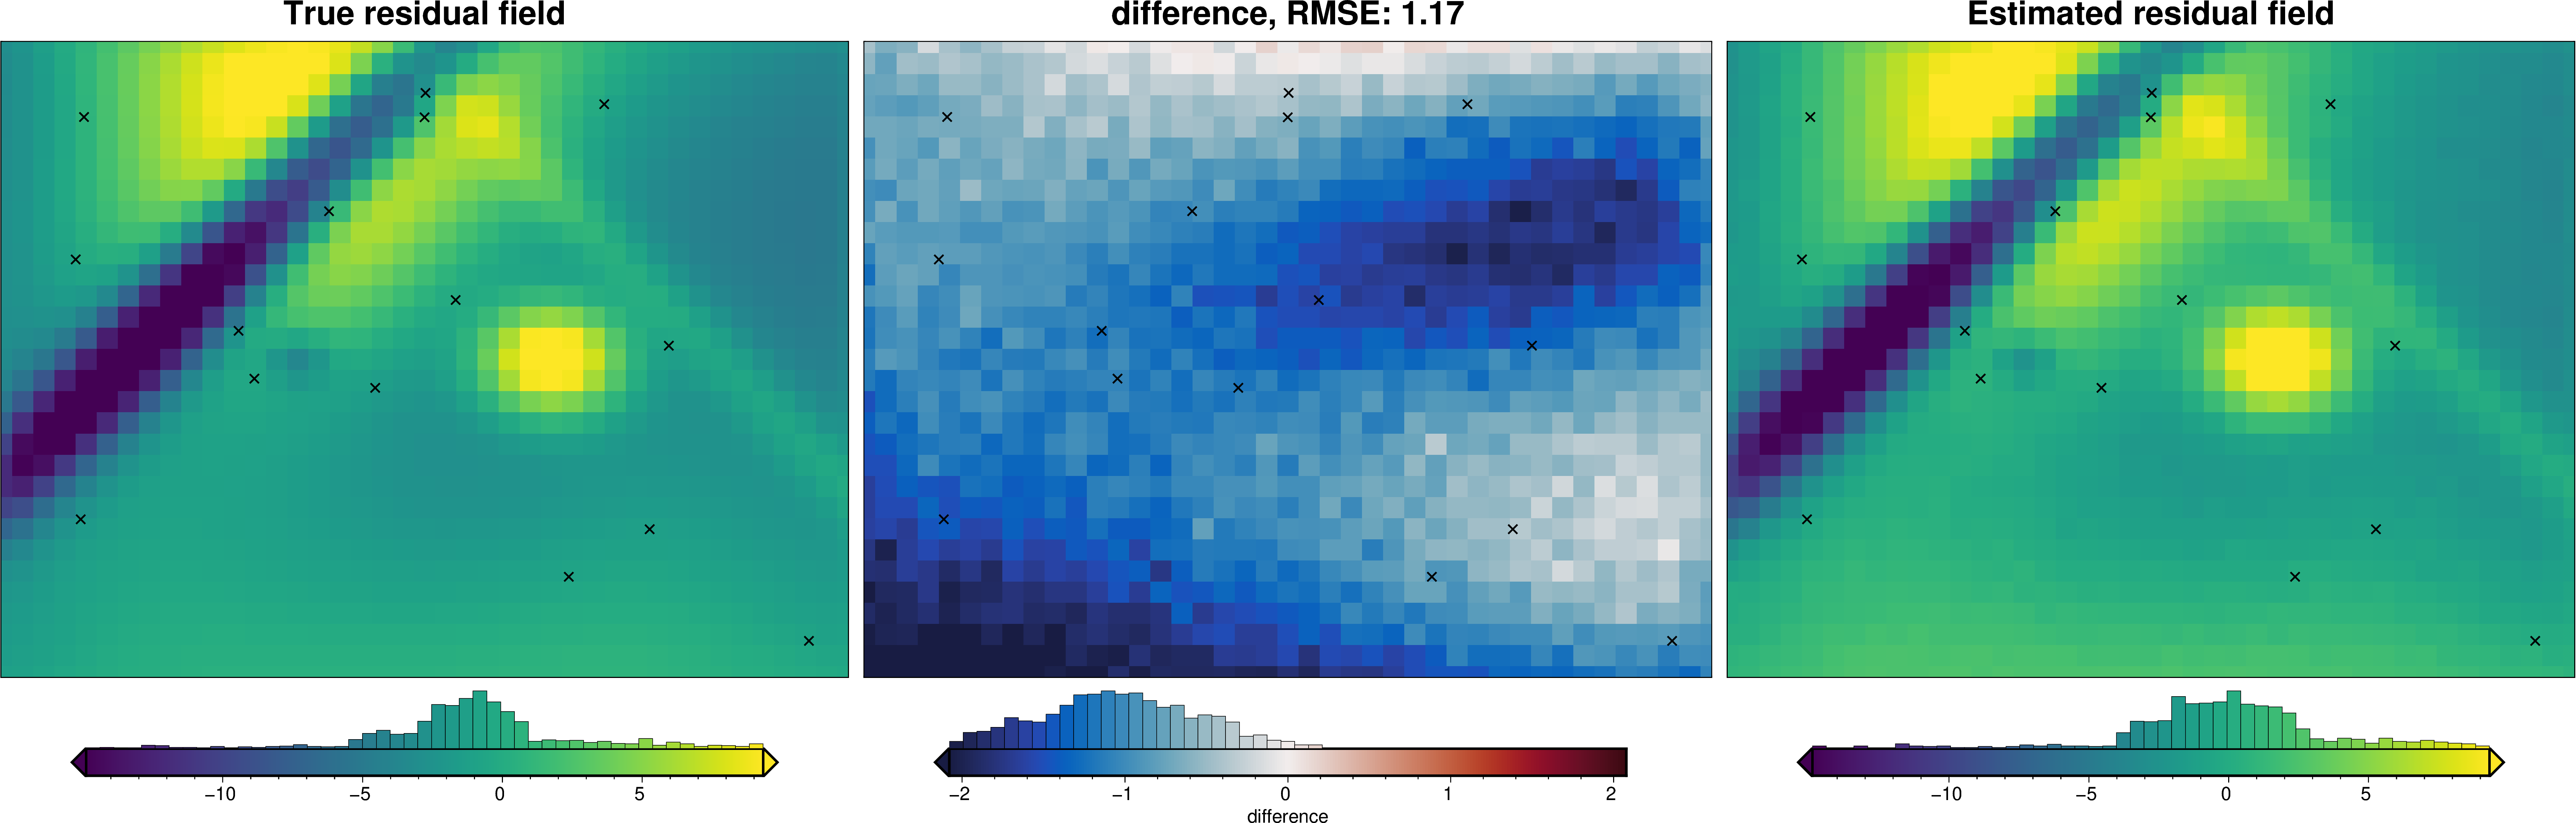

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,starting_gravity,forward_gravity,true_res,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659,-0.124959,-0.124959,1.000000e-01,1.079930,1.079930,-1.209548,-1.204889,-1.050576,-0.154313,1.079930,-1.204889,-1.050576,-0.154313
std,8947.792584,11836.81698,0.0,7.147140,0.830306,7.314752,7.313577,2.776650e-17,6.599125,6.599125,4.456801,4.644997,0.900446,4.422925,6.599125,4.644997,0.900446,4.422925
min,0.000000,0.00000,1001.0,-17.180401,-1.201774,-16.908338,-17.061563,1.000000e-01,-7.883841,-7.883841,-19.046853,-19.654062,-2.394943,-18.179763,-7.883841,-19.654062,-2.394943,-18.179763
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901,-5.826630,-5.827131,1.000000e-01,-3.944309,-3.944309,-2.622186,-2.931387,-1.856976,-1.829846,-3.944309,-2.931387,-1.856976,-1.829846
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953,-0.557795,-0.572175,1.000000e-01,-0.765707,-0.765707,-1.088926,-1.578812,-1.143235,-0.049121,-0.765707,-1.578812,-1.143235,-0.049121
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891,4.171648,4.139840,1.000000e-01,4.823461,4.823461,0.332004,0.296782,-0.286309,1.745587,4.823461,0.296782,-0.286309,1.745587
max,30000.000000,40000.00000,1001.0,19.581120,1.860259,19.774399,19.944612,1.000000e-01,22.159800,22.159800,12.693226,13.114356,0.690206,14.012253,22.159800,13.114356,0.690206,14.012253


In [16]:
# estimate regional with the mean misfit at constraints
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_weights_column="weight",
    constraints_df=constraint_points,
    cv=True,
    cv_kwargs=dict(
        n_trials=50,
        damping_limits=(1e-10, 1),
        # depth_limits=(1e3,100e3),
        progressbar=False,
        fname="../tmp/08_combining_it_all_alternative_regional_sep",
        # plot=True,
    ),
    depth="default",
    block_size=None,
)

data.inv.regional_separation(
    **regional_grav_kwargs,
)

regional_comparison(data)
data.inv.df.describe()

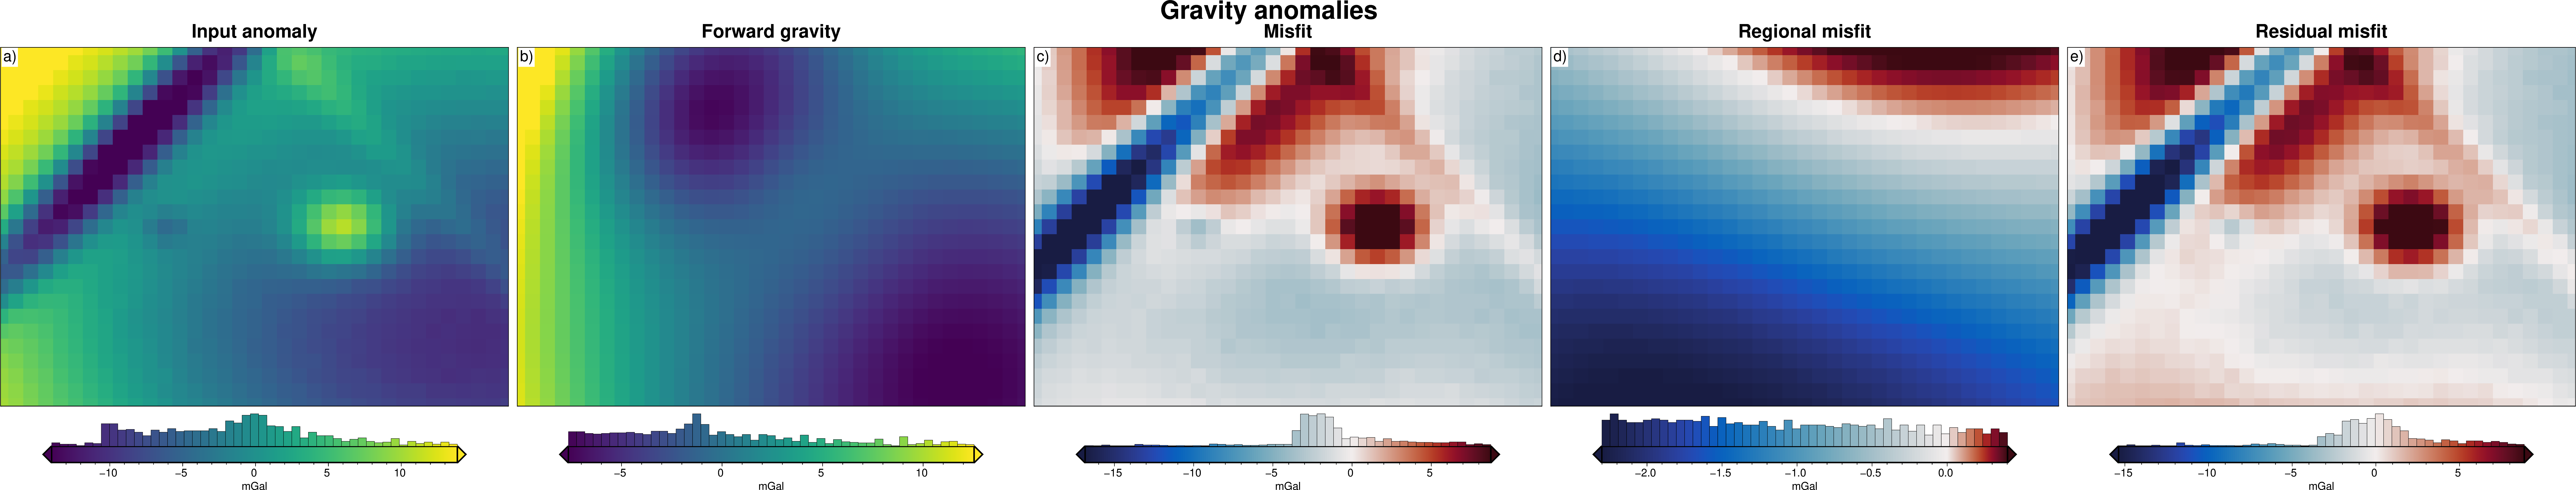

In [17]:
data.inv.plot_anomalies()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

In [18]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.005,
    # set stopping criteria
    l2_norm_tolerance=0.3,  # grav error of .1mGal -> sqrt(.1) = 0.3
    delta_l2_norm_tolerance=1.008,
)

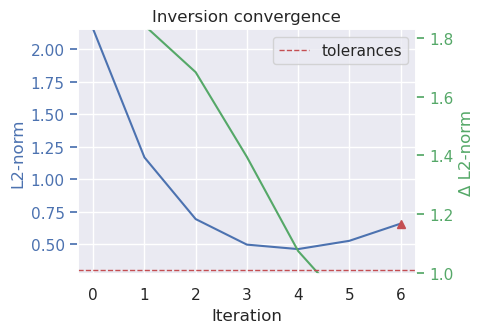

In [19]:
# run the inversion
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/combining_it_all_alternative",
)

In [20]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,4.635934,2.153122,inf,NaN
1,1.0,1.365447,1.168523,1.842601,1.284897
2,2.0,0.481937,0.694217,1.683225,0.388613
3,3.0,0.247785,0.497780,1.394626,0.690483
4,4.0,0.214788,0.463452,1.074070,1.289388
5,5.0,0.277713,0.526985,0.879442,0.709818
6,6.0,0.434185,0.658927,0.799761,0.786403


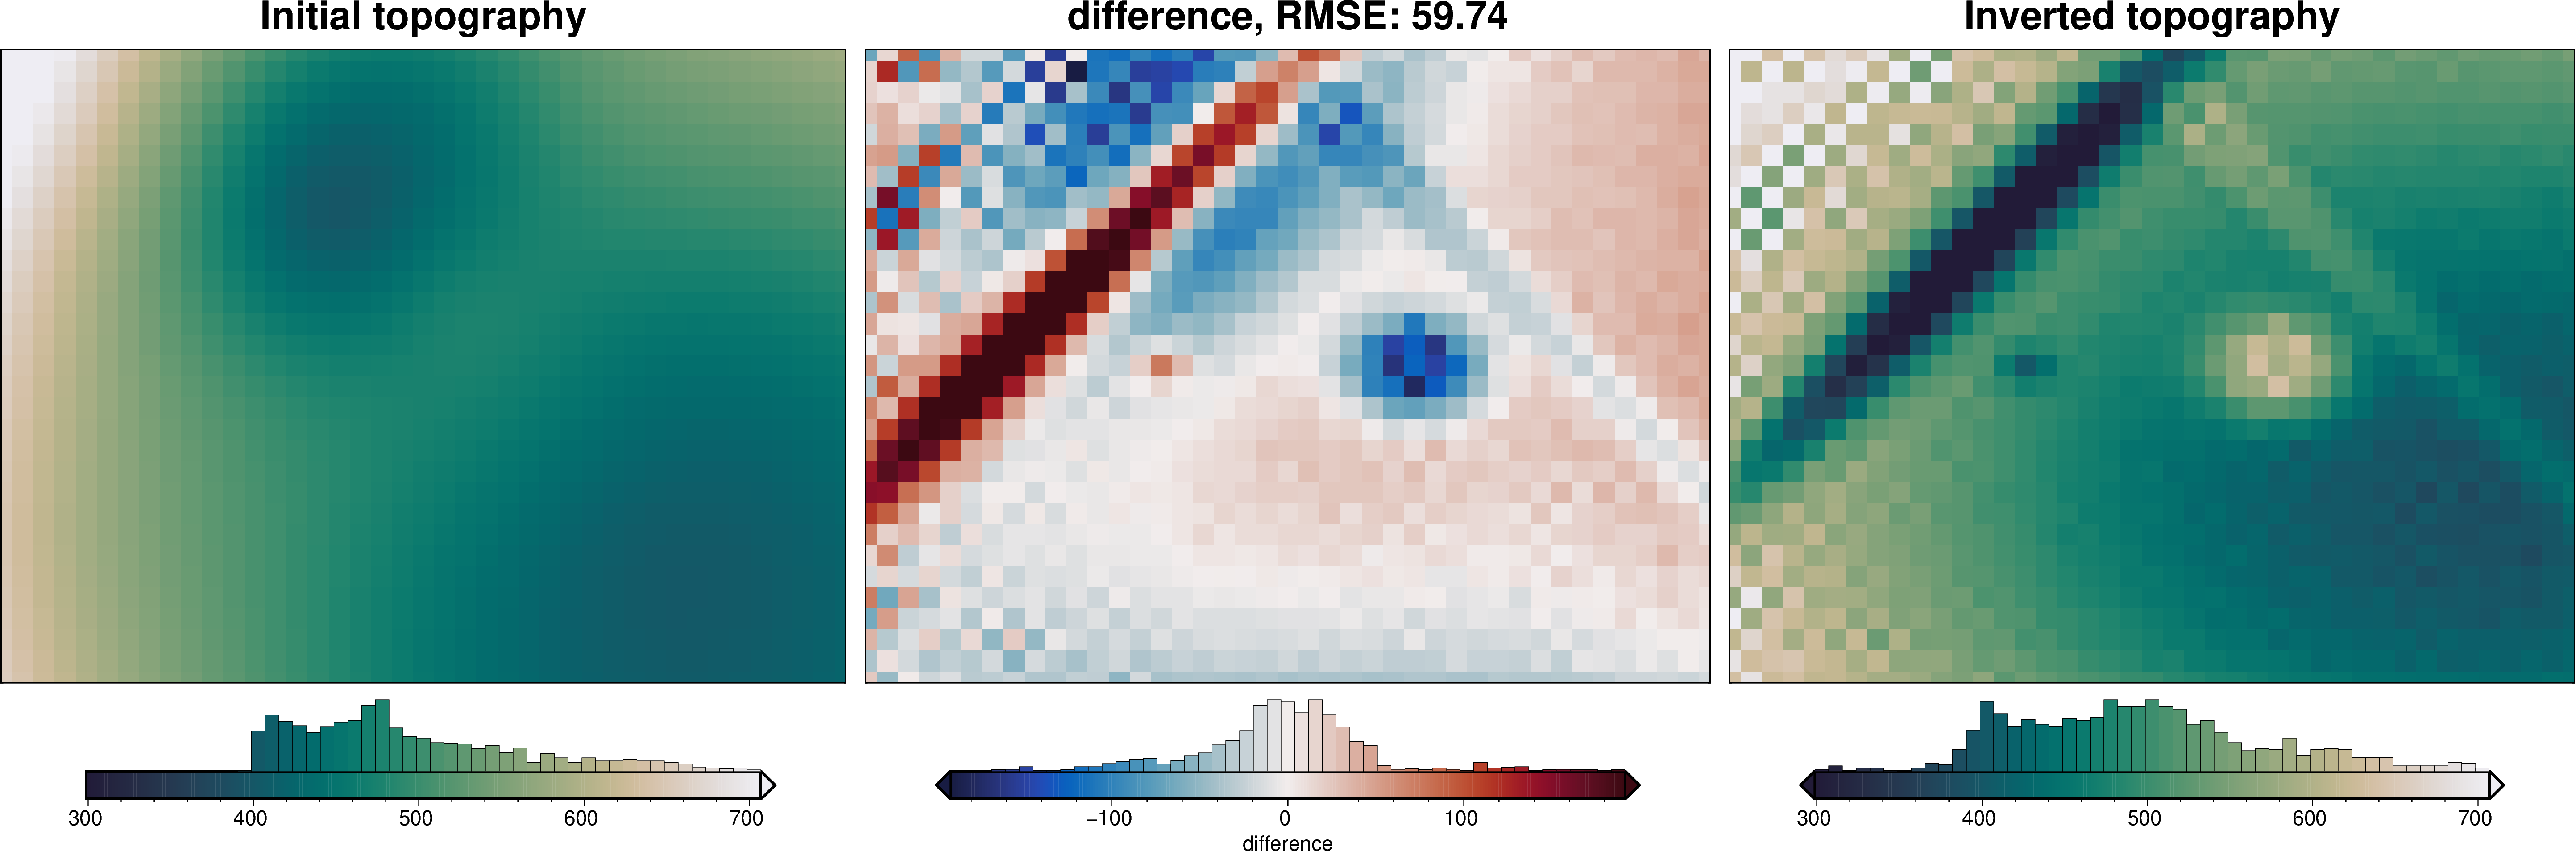

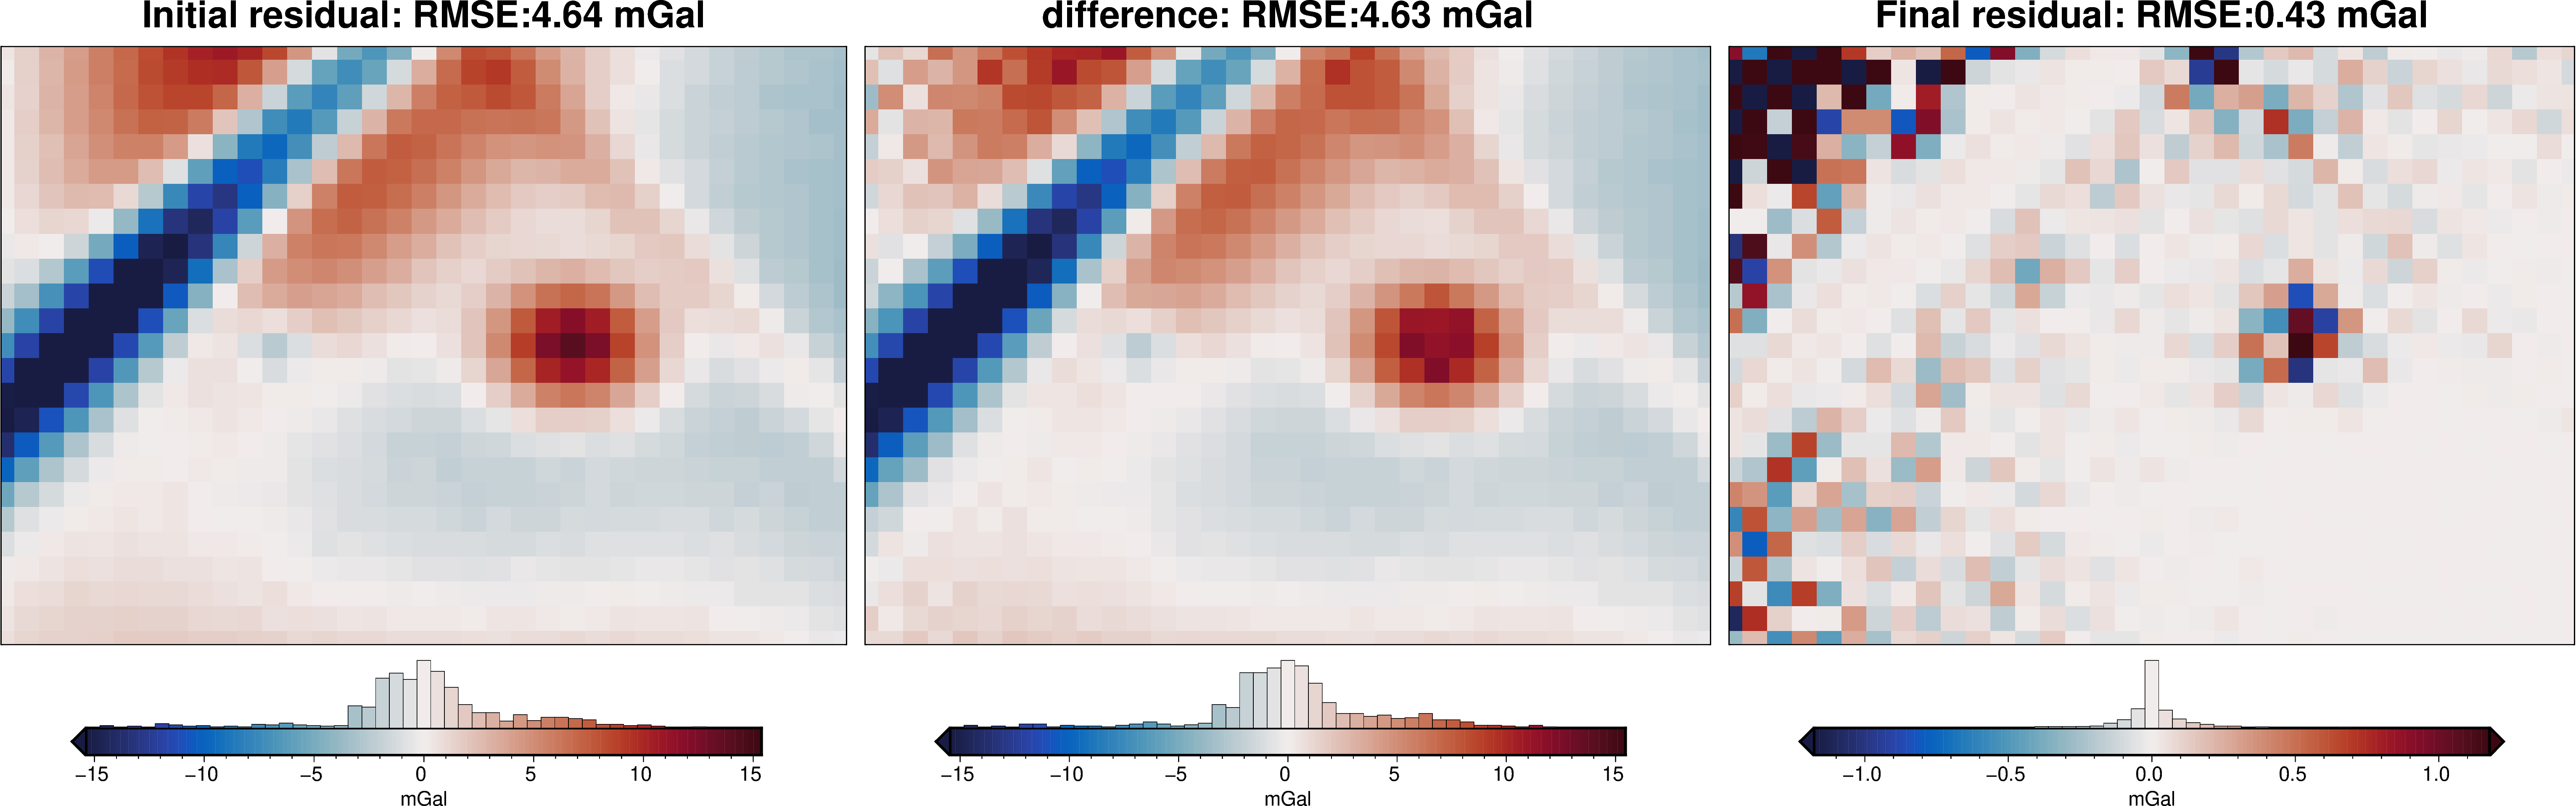

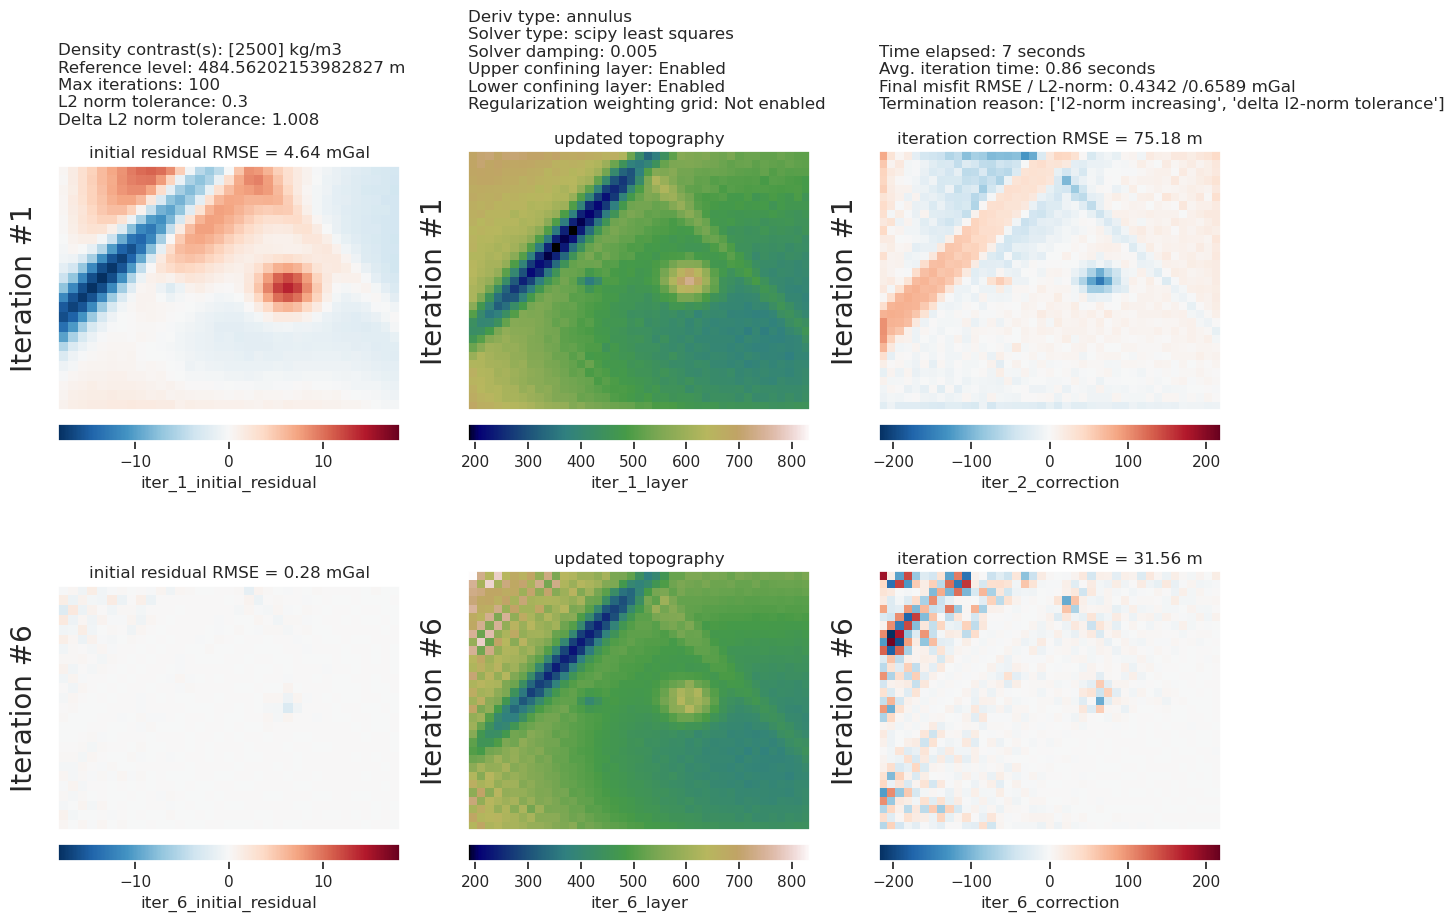

In [21]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

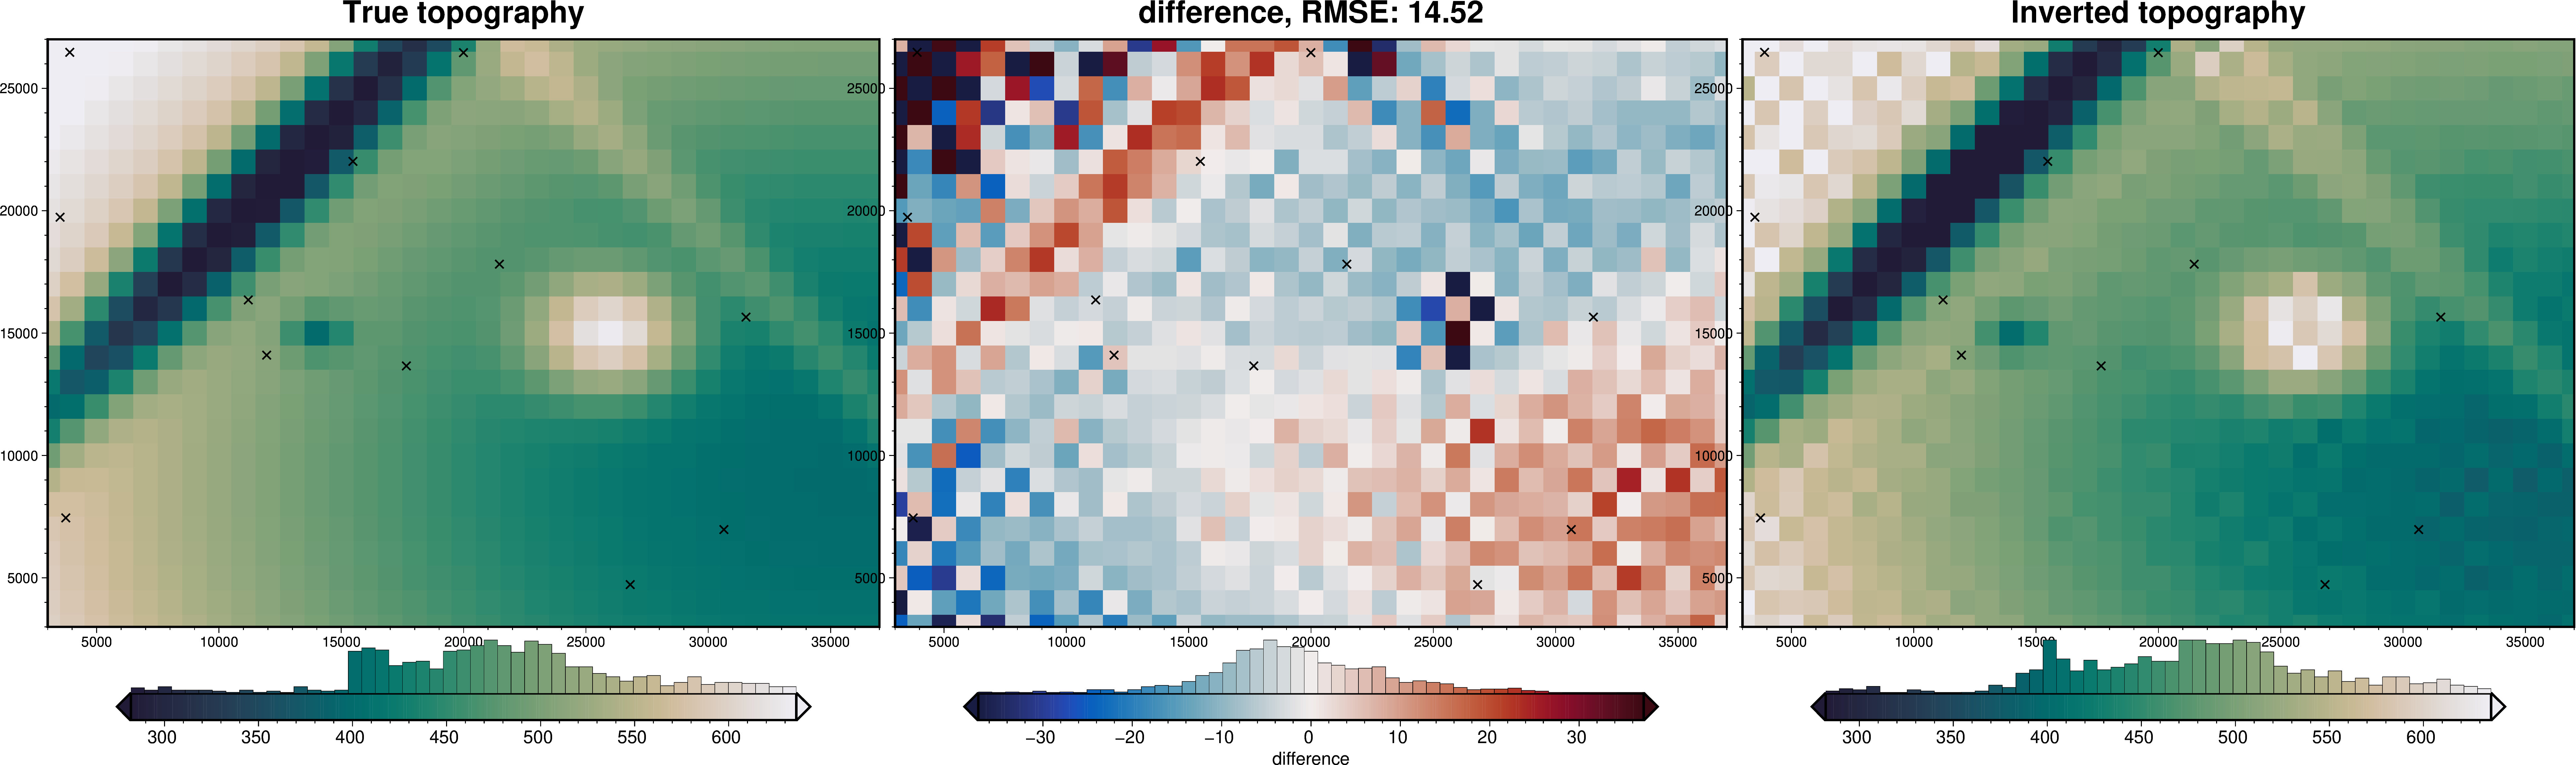

In [22]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    region=data.inner_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    frame=True,
    points=constraint_points,
    points_style="x.3c",
)

## Damping parameter cross validation

### Resample to create testing / training data sets

In [23]:
data.inv.df

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,starting_gravity,forward_gravity,true_res,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,0.0,0.0,1001.0,9.525994,-0.047934,9.478060,9.494673,0.1,10.740517,10.740517,-1.214524,-1.245844,-2.208128,0.962284,10.740517,-1.245844,-2.208128,0.962284
1,0.0,1000.0,1001.0,10.416800,-0.060607,10.356193,10.347023,0.1,11.470352,11.470352,-1.053551,-1.123328,-2.238812,1.115483,11.470352,-1.123328,-2.238812,1.115483
2,0.0,2000.0,1001.0,9.945126,-0.079985,9.865141,9.933223,0.1,10.699837,10.699837,-0.754711,-0.766613,-2.267089,1.500476,10.699837,-0.766613,-2.267089,1.500476
3,0.0,3000.0,1001.0,9.265122,-0.102636,9.162486,9.177017,0.1,9.740384,9.740384,-0.475262,-0.563367,-2.292787,1.729420,9.740384,-0.563367,-2.292787,1.729420
4,0.0,4000.0,1001.0,8.528509,-0.126515,8.401994,8.352468,0.1,8.762056,8.762056,-0.233547,-0.409588,-2.315764,1.906176,8.762056,-0.409588,-2.315764,1.906176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1001.0,3.330540,0.765378,4.095918,3.988219,0.1,5.931613,5.931613,-2.601073,-1.943393,0.557821,-2.501215,5.931613,-1.943393,0.557821,-2.501215
1267,30000.0,37000.0,1001.0,3.328091,0.745878,4.073969,4.144597,0.1,6.177712,6.177712,-2.849622,-2.033116,0.529662,-2.562778,6.177712,-2.033116,0.529662,-2.562778
1268,30000.0,38000.0,1001.0,3.333133,0.706587,4.039719,4.073005,0.1,6.390391,6.390391,-3.057258,-2.317386,0.500180,-2.817567,6.390391,-2.317386,0.500180,-2.817567
1269,30000.0,39000.0,1001.0,3.298196,0.634280,3.932475,3.841945,0.1,6.478970,6.478970,-3.180774,-2.637025,0.469725,-3.106750,6.478970,-2.637025,0.469725,-3.106750


In [24]:
inv.data.inv.df.columns

Index(['northing', 'easting', 'upward', 'upper_surface_grav',
       'lower_surface_grav', 'gravity_anomaly_no_noise', 'gravity_anomaly',
       'uncert', 'starting_gravity', 'forward_gravity', 'true_res', 'misfit',
       'reg', 'res', 'starting_forward_gravity', 'starting_misfit',
       'starting_reg', 'starting_res', 'iter_1_initial_residual',
       'iter_2_initial_residual', 'iter_3_initial_residual',
       'iter_4_initial_residual', 'iter_5_initial_residual',
       'iter_6_initial_residual'],
      dtype='object')

In [25]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)

In [26]:
inv.reinitialize_inversion()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.02248075164479063

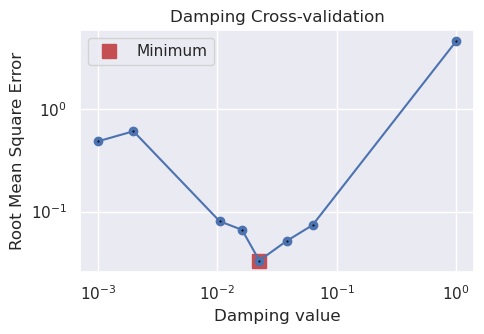

In [27]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    fname="../tmp/08_combining_it_all_alternative_damping_CV",
)
inv.solver_damping

In [28]:
damping_cv_obj.study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_damping,user_attrs_fname,system_attrs_fixed_params,state
0,0,0.485299,2025-10-07 17:19:59.770632,2025-10-07 17:20:03.103758,0 days 00:00:03.333126,0.001000,../tmp/08_combining_it_all_alternative_damping...,{'damping': 0.001},COMPLETE
1,1,4.592442,2025-10-07 17:20:03.112086,2025-10-07 17:20:04.251865,0 days 00:00:01.139779,1.000000,../tmp/08_combining_it_all_alternative_damping...,{'damping': 1},COMPLETE
2,2,0.608820,2025-10-07 17:20:04.253069,2025-10-07 17:20:06.615827,0 days 00:00:02.362758,0.001983,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE
3,3,0.073819,2025-10-07 17:20:06.617659,2025-10-07 17:20:09.675367,0 days 00:00:03.057708,0.062714,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE
4,4,0.033303,2025-10-07 17:20:09.686080,2025-10-07 17:20:11.456891,0 days 00:00:01.770811,0.022481,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE
5,5,0.051702,2025-10-07 17:20:11.458217,2025-10-07 17:20:13.686762,0 days 00:00:02.228545,0.038008,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE
6,6,0.080539,2025-10-07 17:20:13.693997,2025-10-07 17:20:16.540099,0 days 00:00:02.846102,0.010463,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE
7,7,0.066448,2025-10-07 17:20:16.541226,2025-10-07 17:20:18.639102,0 days 00:00:02.097876,0.016105,../tmp/08_combining_it_all_alternative_damping...,NaN,COMPLETE


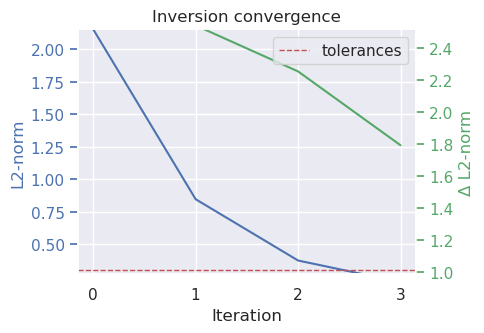

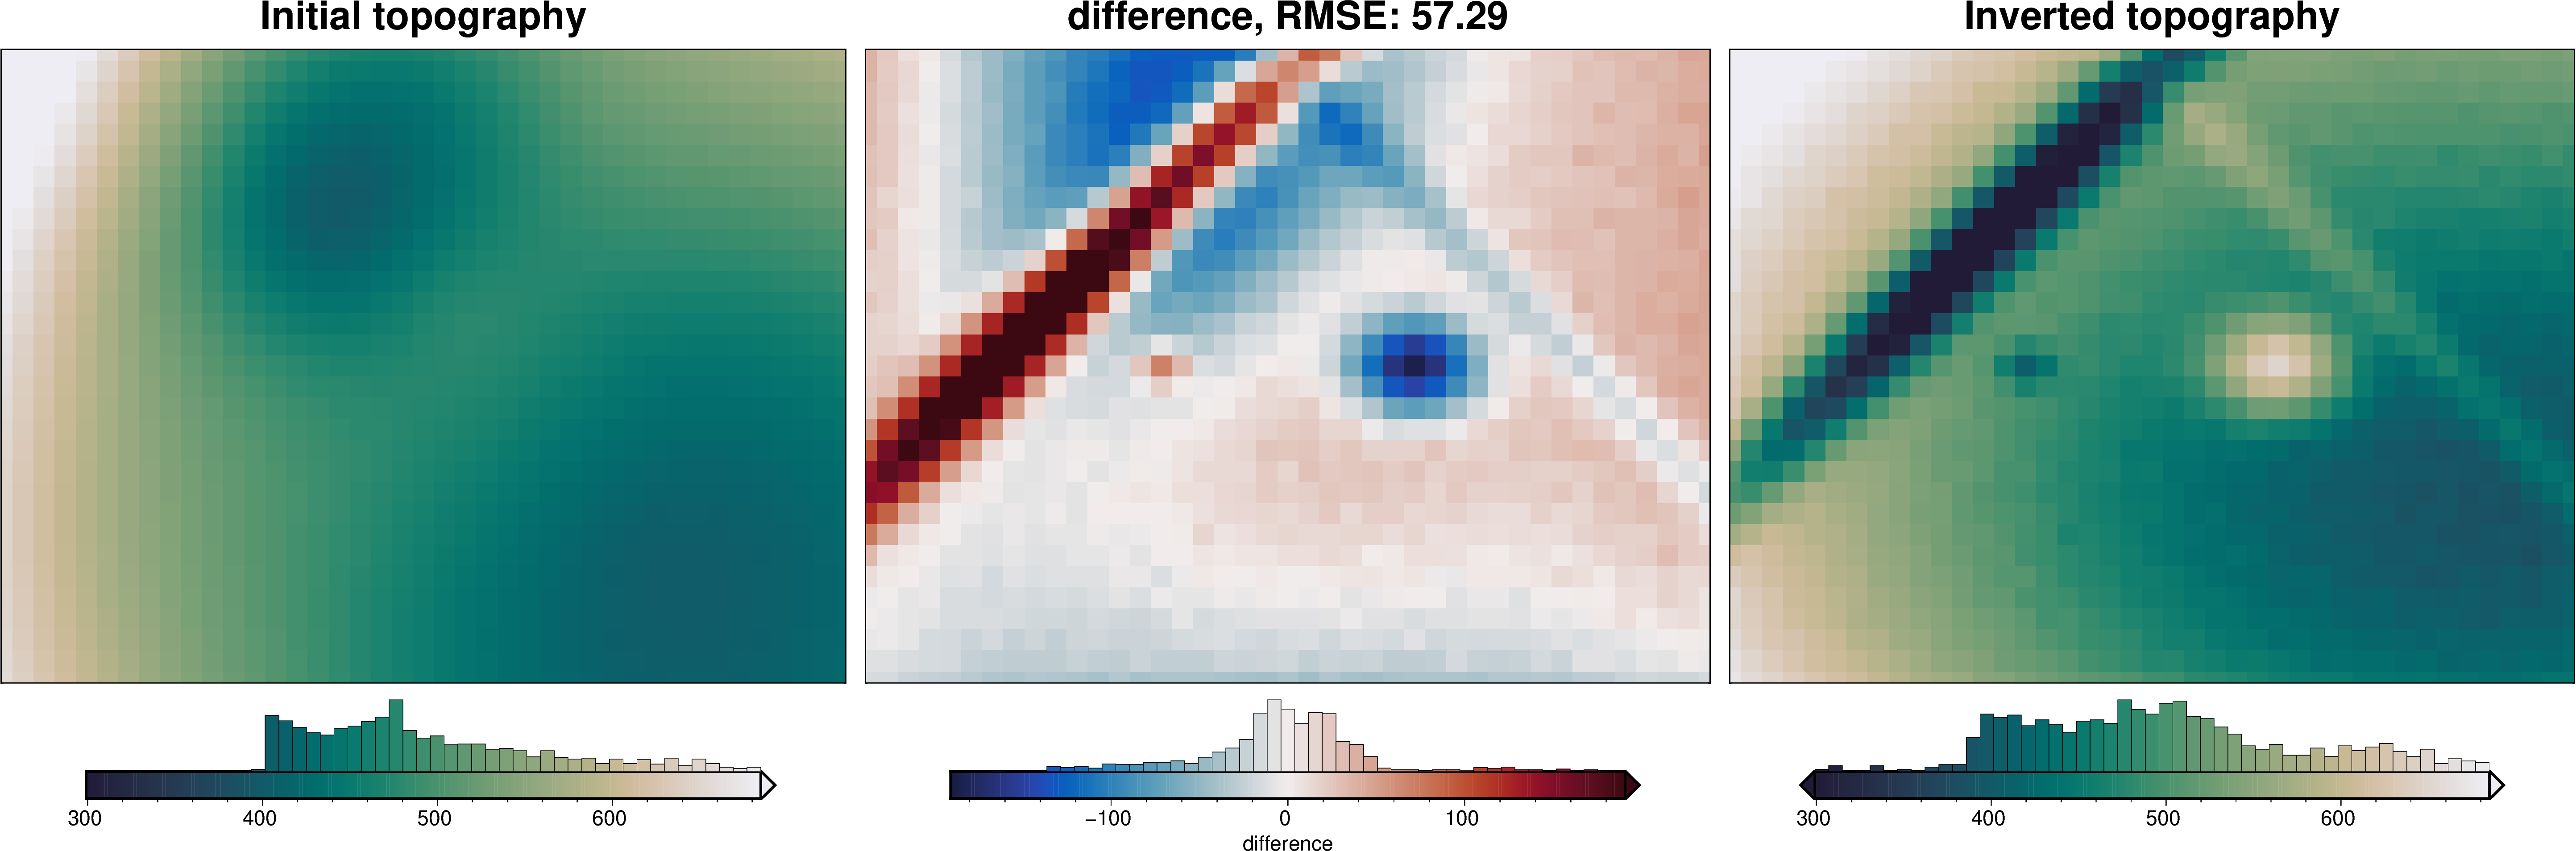

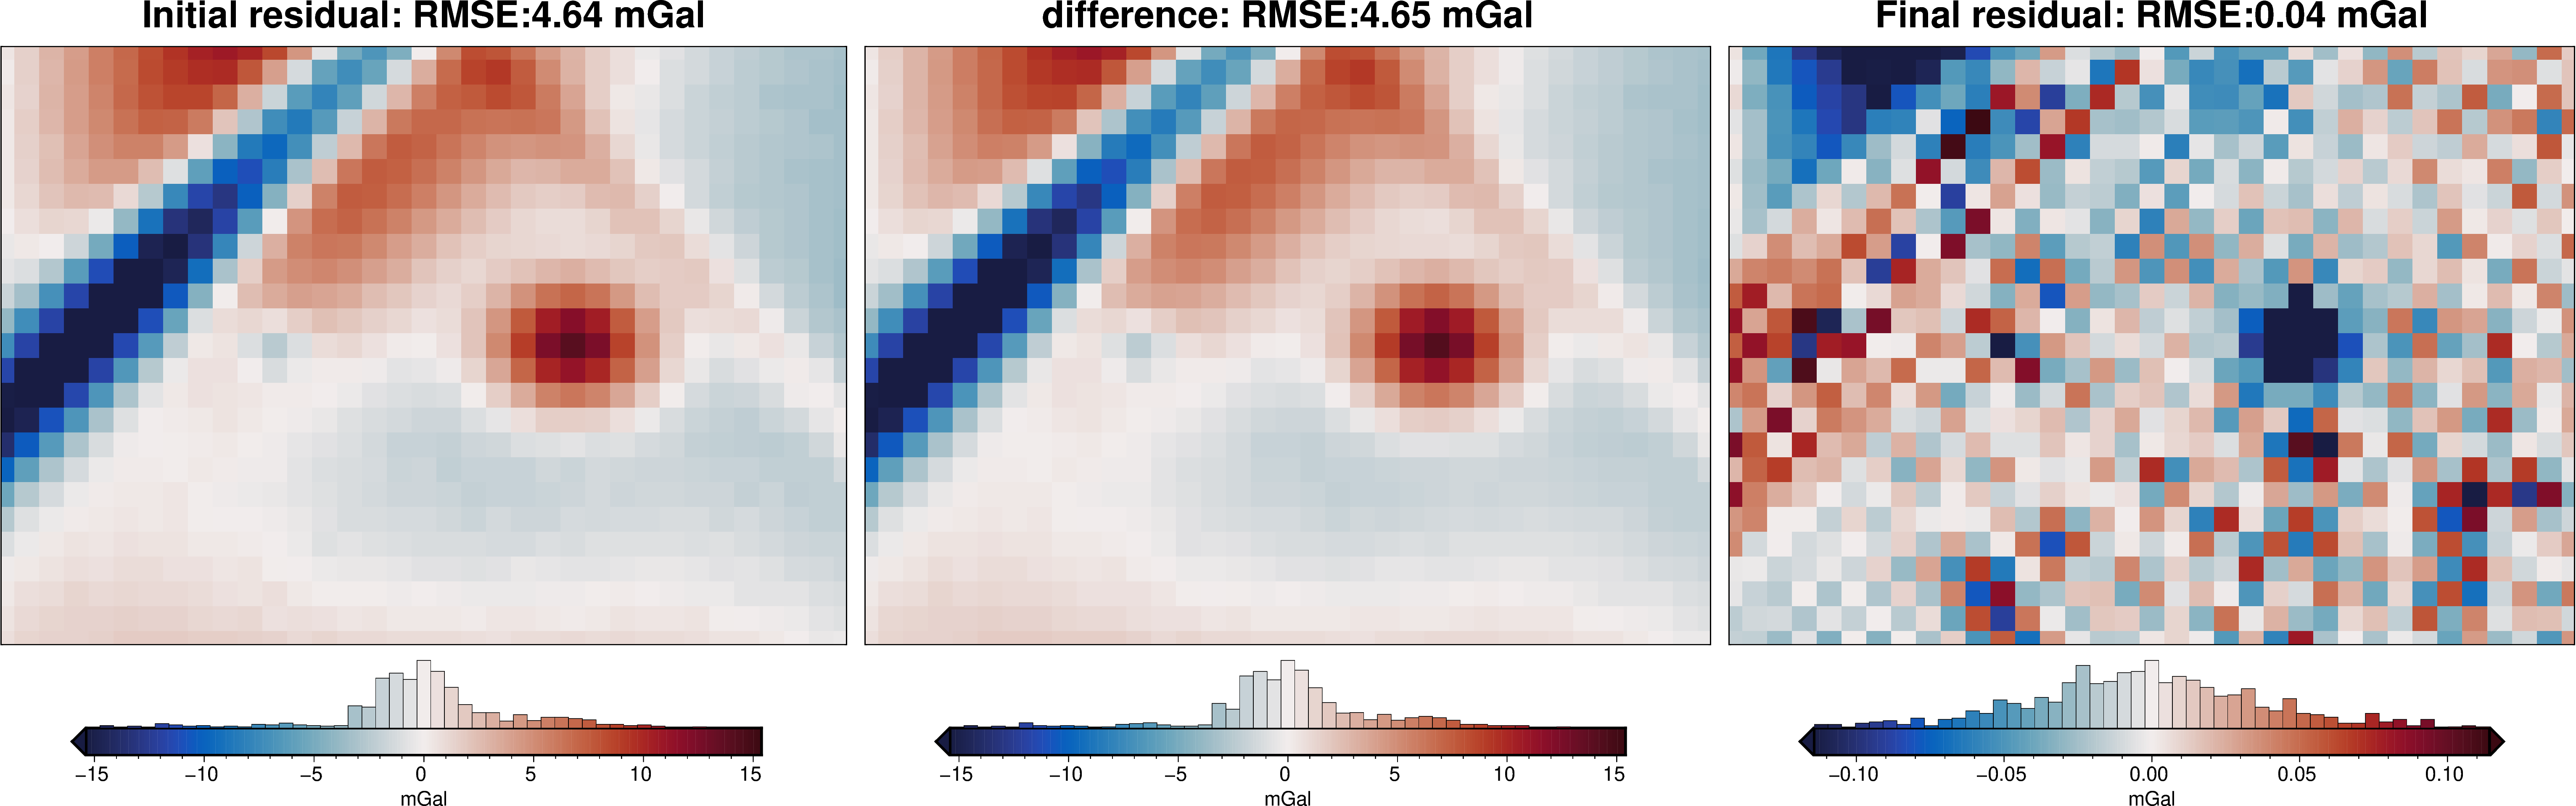

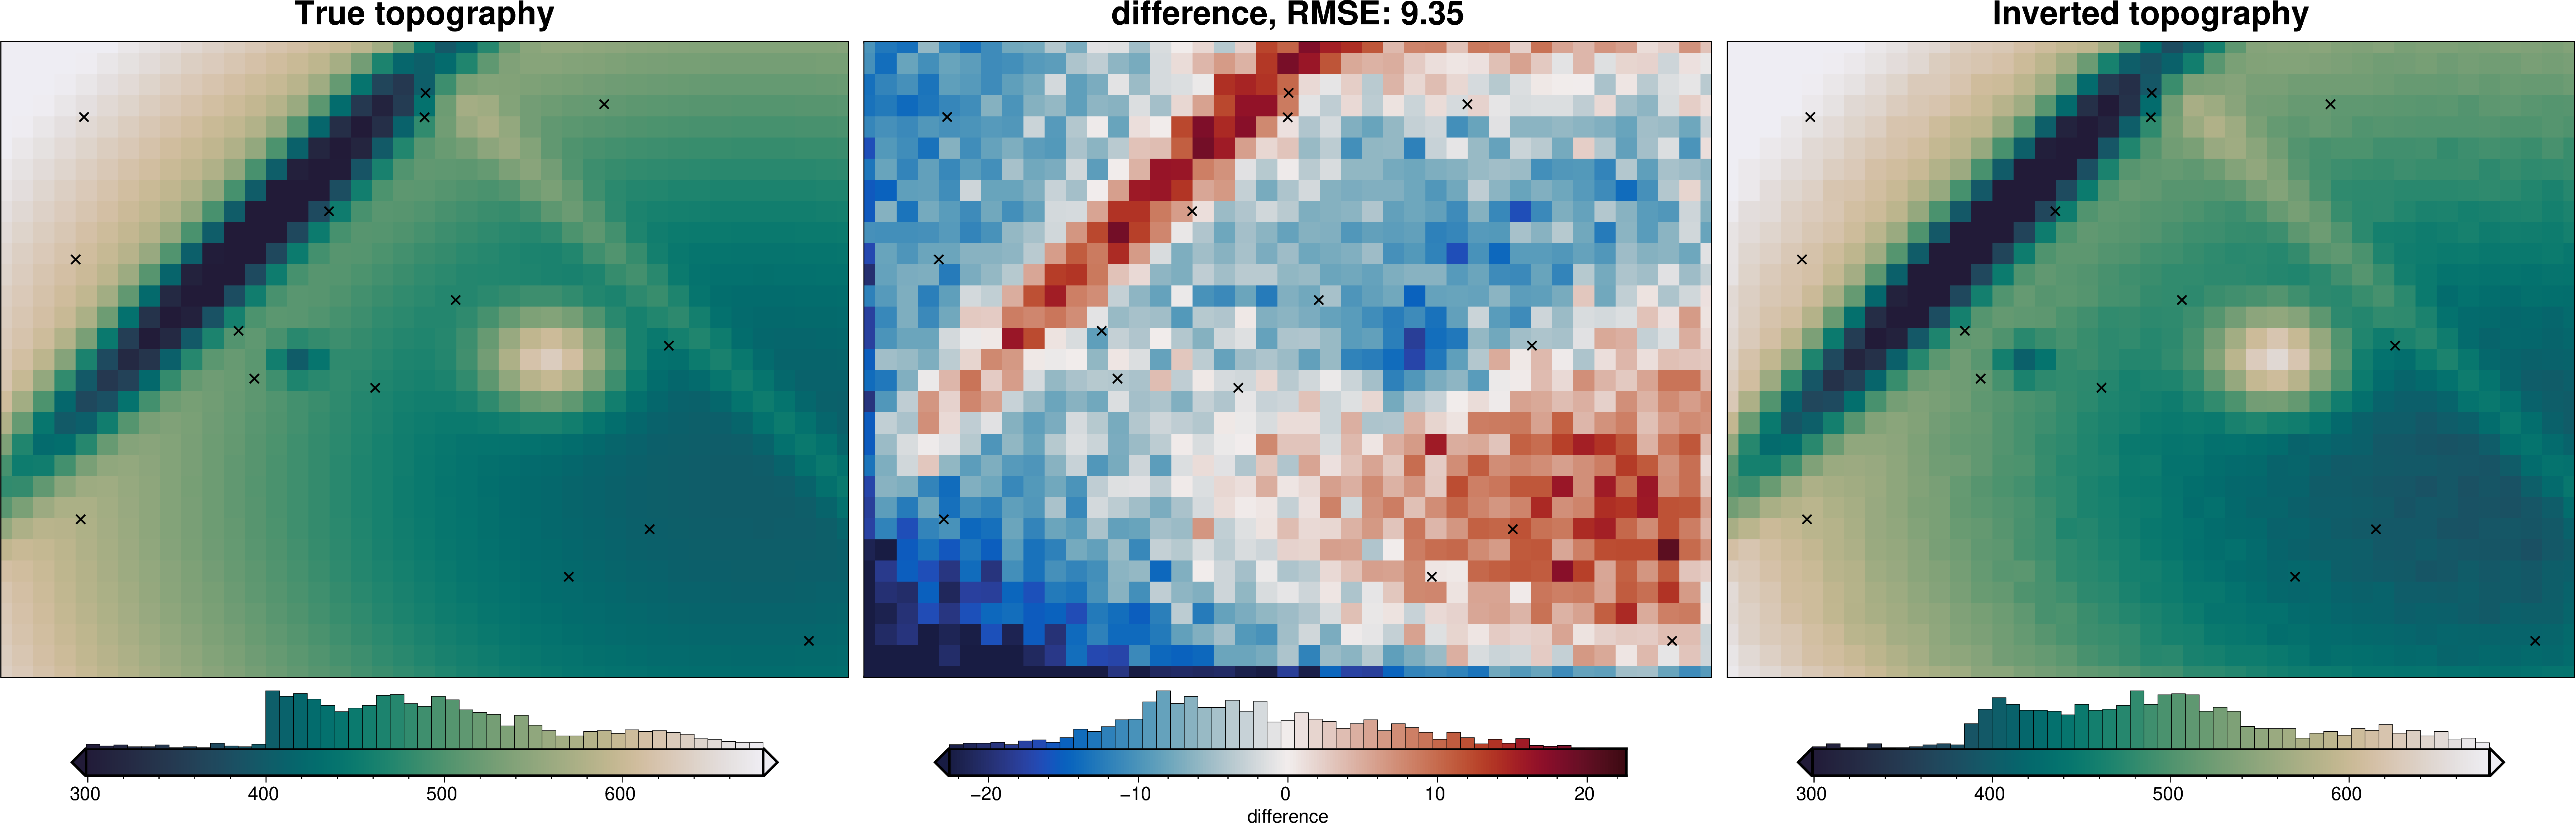

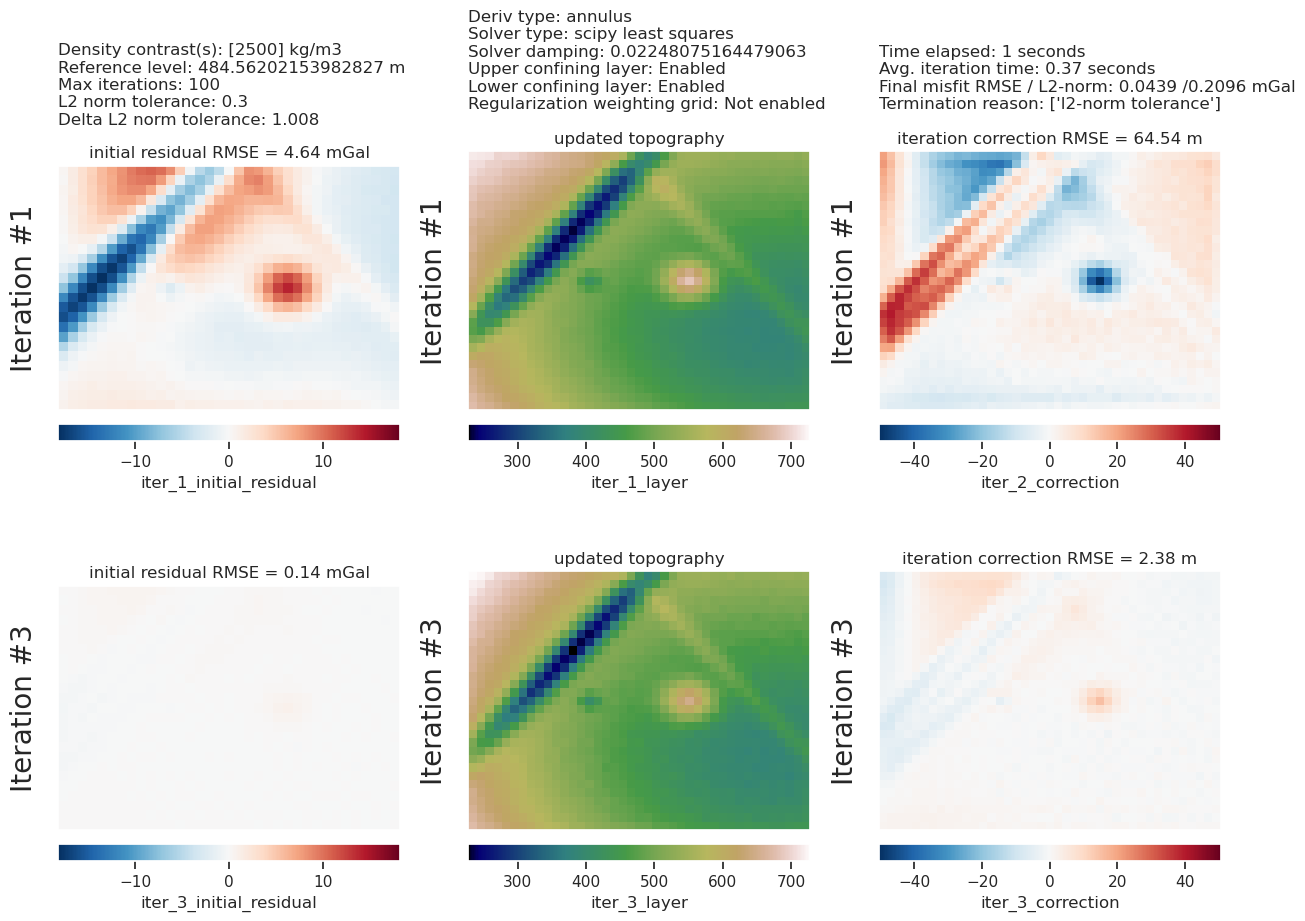

In [29]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [30]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 10.02 m


## Z-ref and density contrast optimizations
Since this cross validation uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the cross validation scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast value, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) separate the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring the density contrast cross validation. 

Since we have constraint points, we will just use their mean value as the zref and omit the zref CV. 

Well perform just the **second** method below:

This option is less efficient, but in some cases may be more accurate.

Perform a cross validation for the optimal zref and density contrast values same as function optimize_inversion_zref_density_contrast, but pass a dataframe of constraint points which contains folds of testing and training data (generated with cross_validation.split_test_train). For each set of zref/density values, recreate the starting topography with the supplied starting_topography_kwargs, recreate the starting prism model, and perform a regional separation and inversion for each of the K folds in the constraints dataframe.

After all K folds are inverted, the mean of the K folds scores will be the score for that set of parameters. Repeat this for all parameters. Within each fold, the training constraints are used for the regional separation and the testing constraints are used for scoring. This is only useful if the regional separation technique you supply via regional_grav_kwargs uses constraints points for the estimations, such as constraint point minimization. If using 20 sets of density and zref values, and use 5 folds, this will run 100 inversions. It is more efficient, but less accurate, to simple use a different regional estimation technique, which doesn’t require constraint points, to find the optimal zref and density values. Then use these again in another inversion with the desired regional separation technique.

In [31]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [32]:
inv.reinitialize_inversion()

In [33]:
# run a 5-fold cross validation for 15 parameter sets of density and zref
density_zref_cv_obj = inv.optimize_inversion_zref_density_contrast_kfolds(
    constraints_df=constraint_points,
    density_contrast_limits=(2300, 3000),
    zref_limits=(0, 1e3),
    n_trials=15,
    regional_grav_kwargs=regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
    plot_cv=False,
    fname="../tmp/08_combining_it_all_alternative_density_and_zref_cv",
    split_kwargs=dict(
        n_splits=5,
        method="KFold",
    ),
    fold_progressbar=False,
)

  0%|          | 0/8 [00:00<?, ?it/s]

Best damping value (1e-10) is at the limit of provided values (1.0, 1e-10) and thus is likely not a global minimum, expand the range of values tested to ensure the best parameter value is found.
Best damping value (1e-40) is at the limit of provided values (1e-40, 1.0) and thus is likely not a global minimum, expand the range of values test to ensure the best parameter value value is found.


  0%|          | 0/7 [00:00<?, ?it/s]

Best damping value (1.0) is at the limit of provided values (1.0, 1e-10) and thus is likely not a global minimum, expand the range of values tested to ensure the best parameter value is found.
Best damping value (1e-40) is at the limit of provided values (1e-40, 1.0) and thus is likely not a global minimum, expand the range of values test to ensure the best parameter value value is found.
'starting_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True
'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [34]:
# to re-load the inv object from the saved pickle file
with pathlib.Path(
    "../tmp/08_combining_it_all_alternative_density_and_zref_cv_results.pickle"
).open("rb") as f:
    inv = pickle.load(f)

# to re-load the study from the saved pickle file
with pathlib.Path(
    "../tmp/08_combining_it_all_alternative_density_and_zref_cv_results_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

inv.solver_damping, inv.model.density_contrast, inv.model.zref

(0.01934388969674529, 2805, 599.1217798843752)

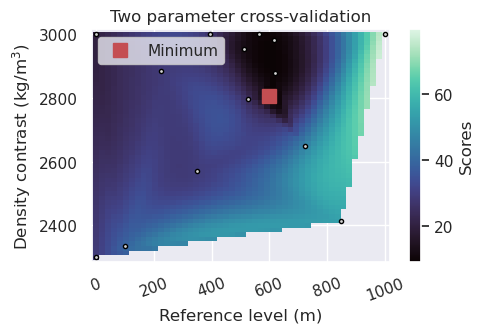

In [35]:
fig = invert4geom.plot_2_parameter_cv_scores_uneven(
    density_zref_cv_obj.study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

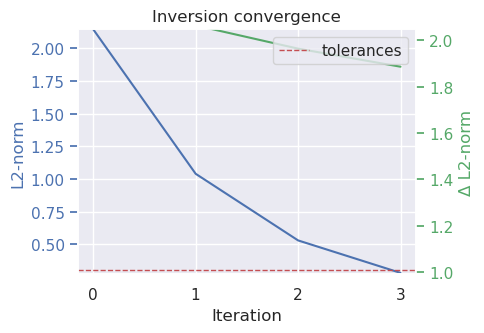

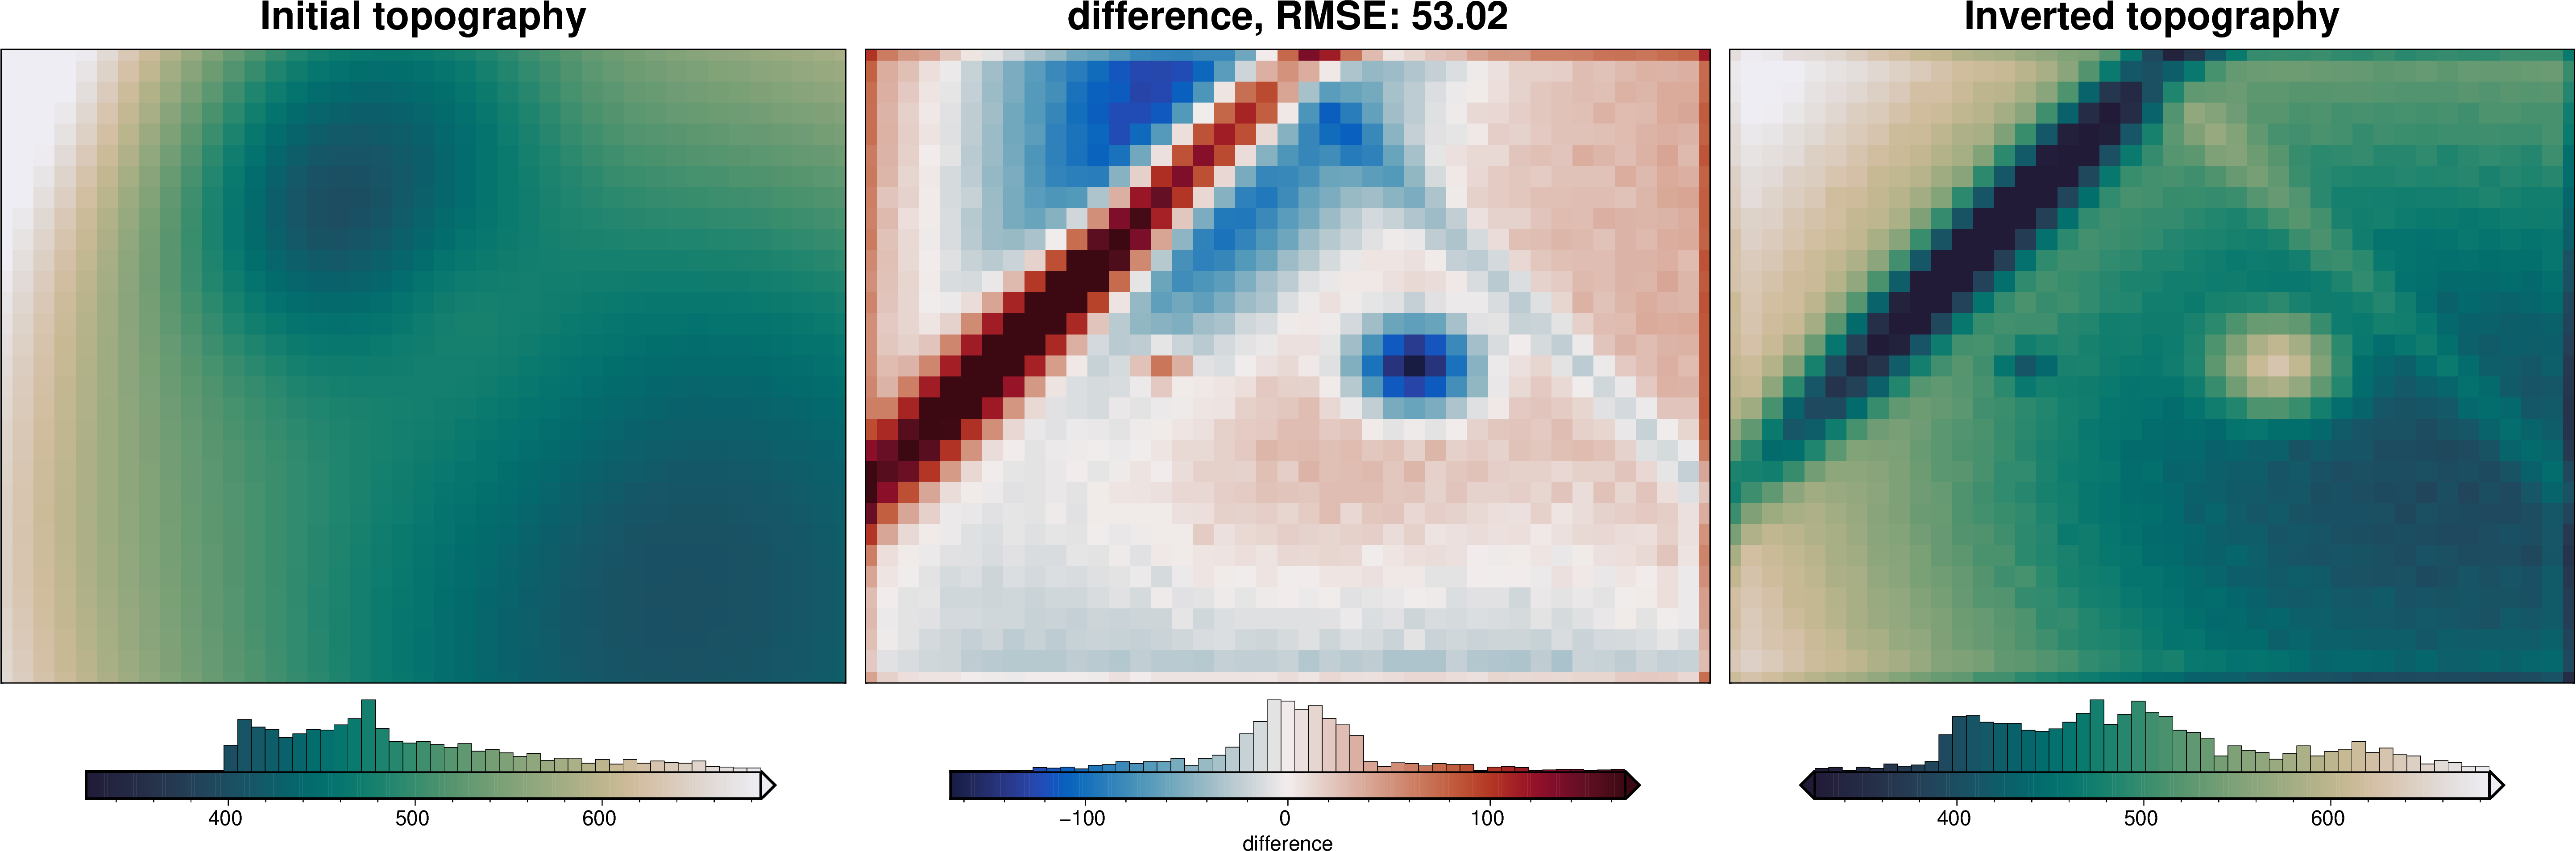

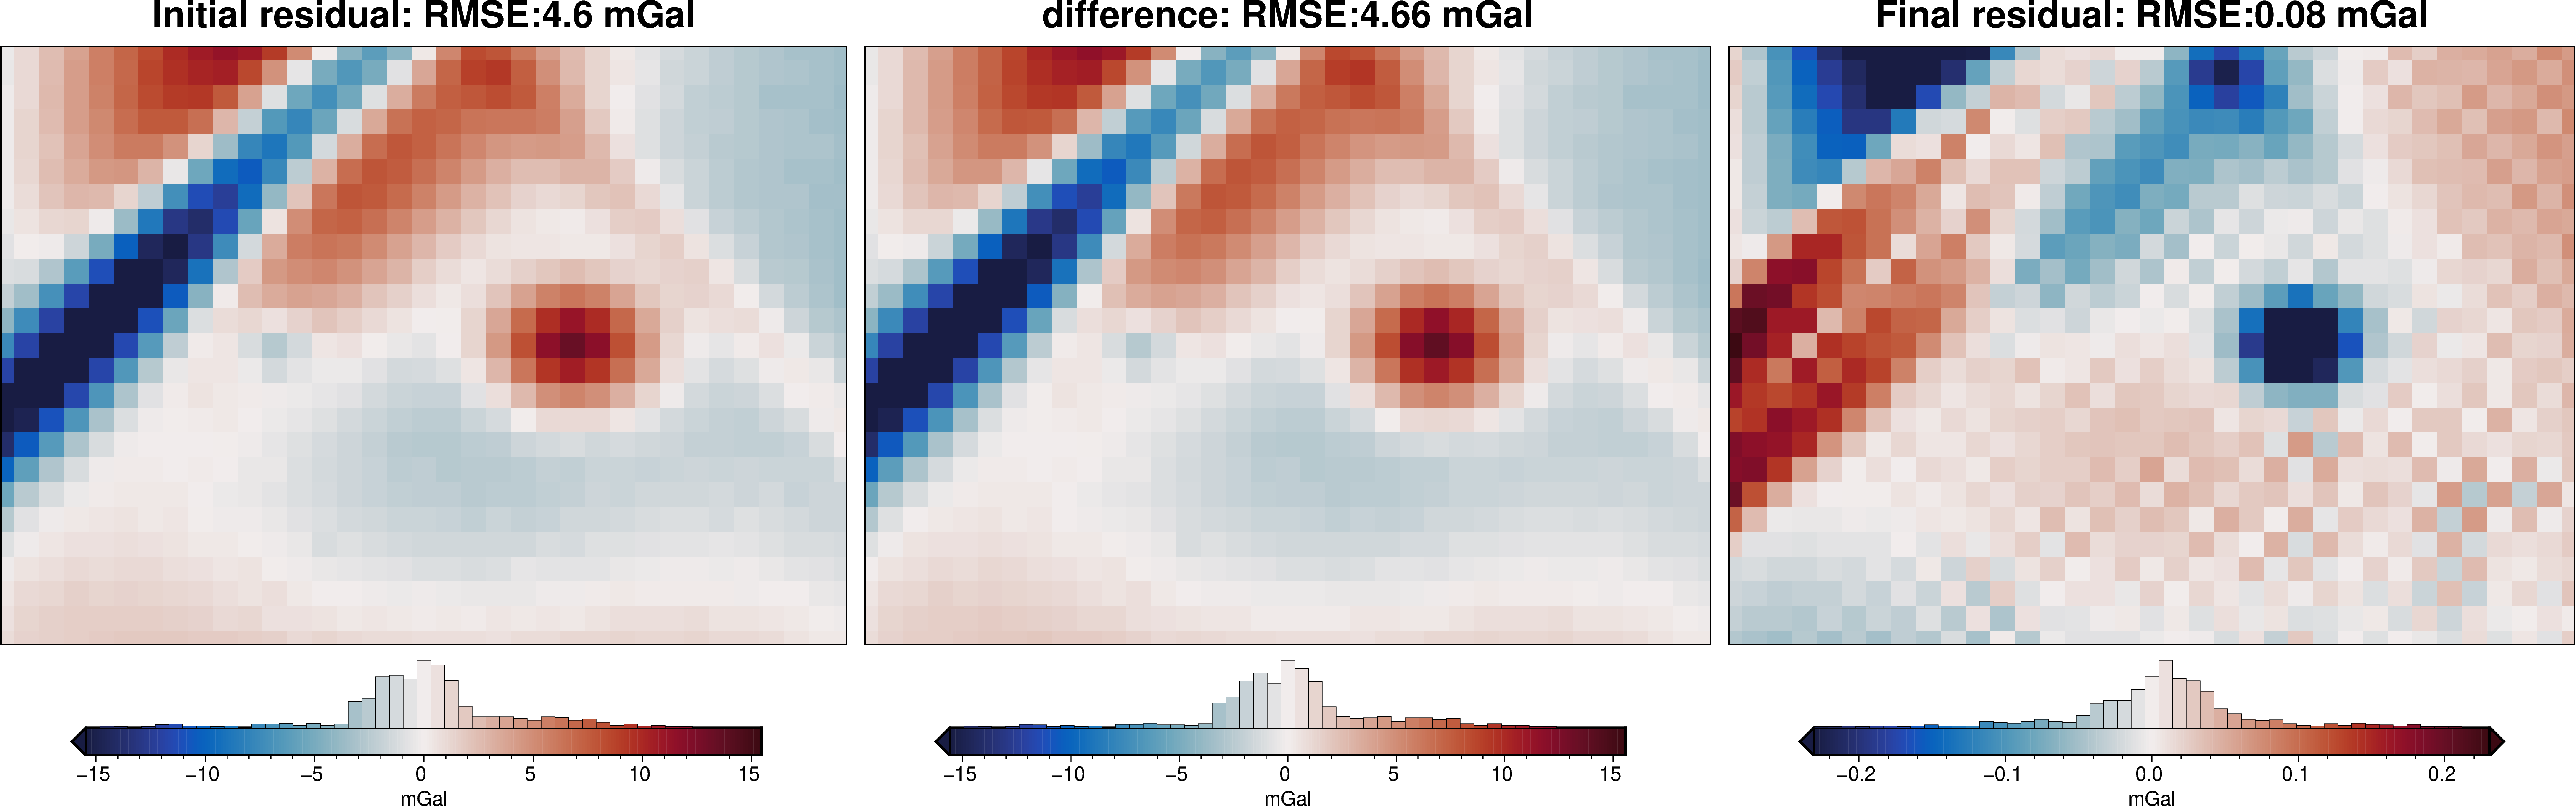

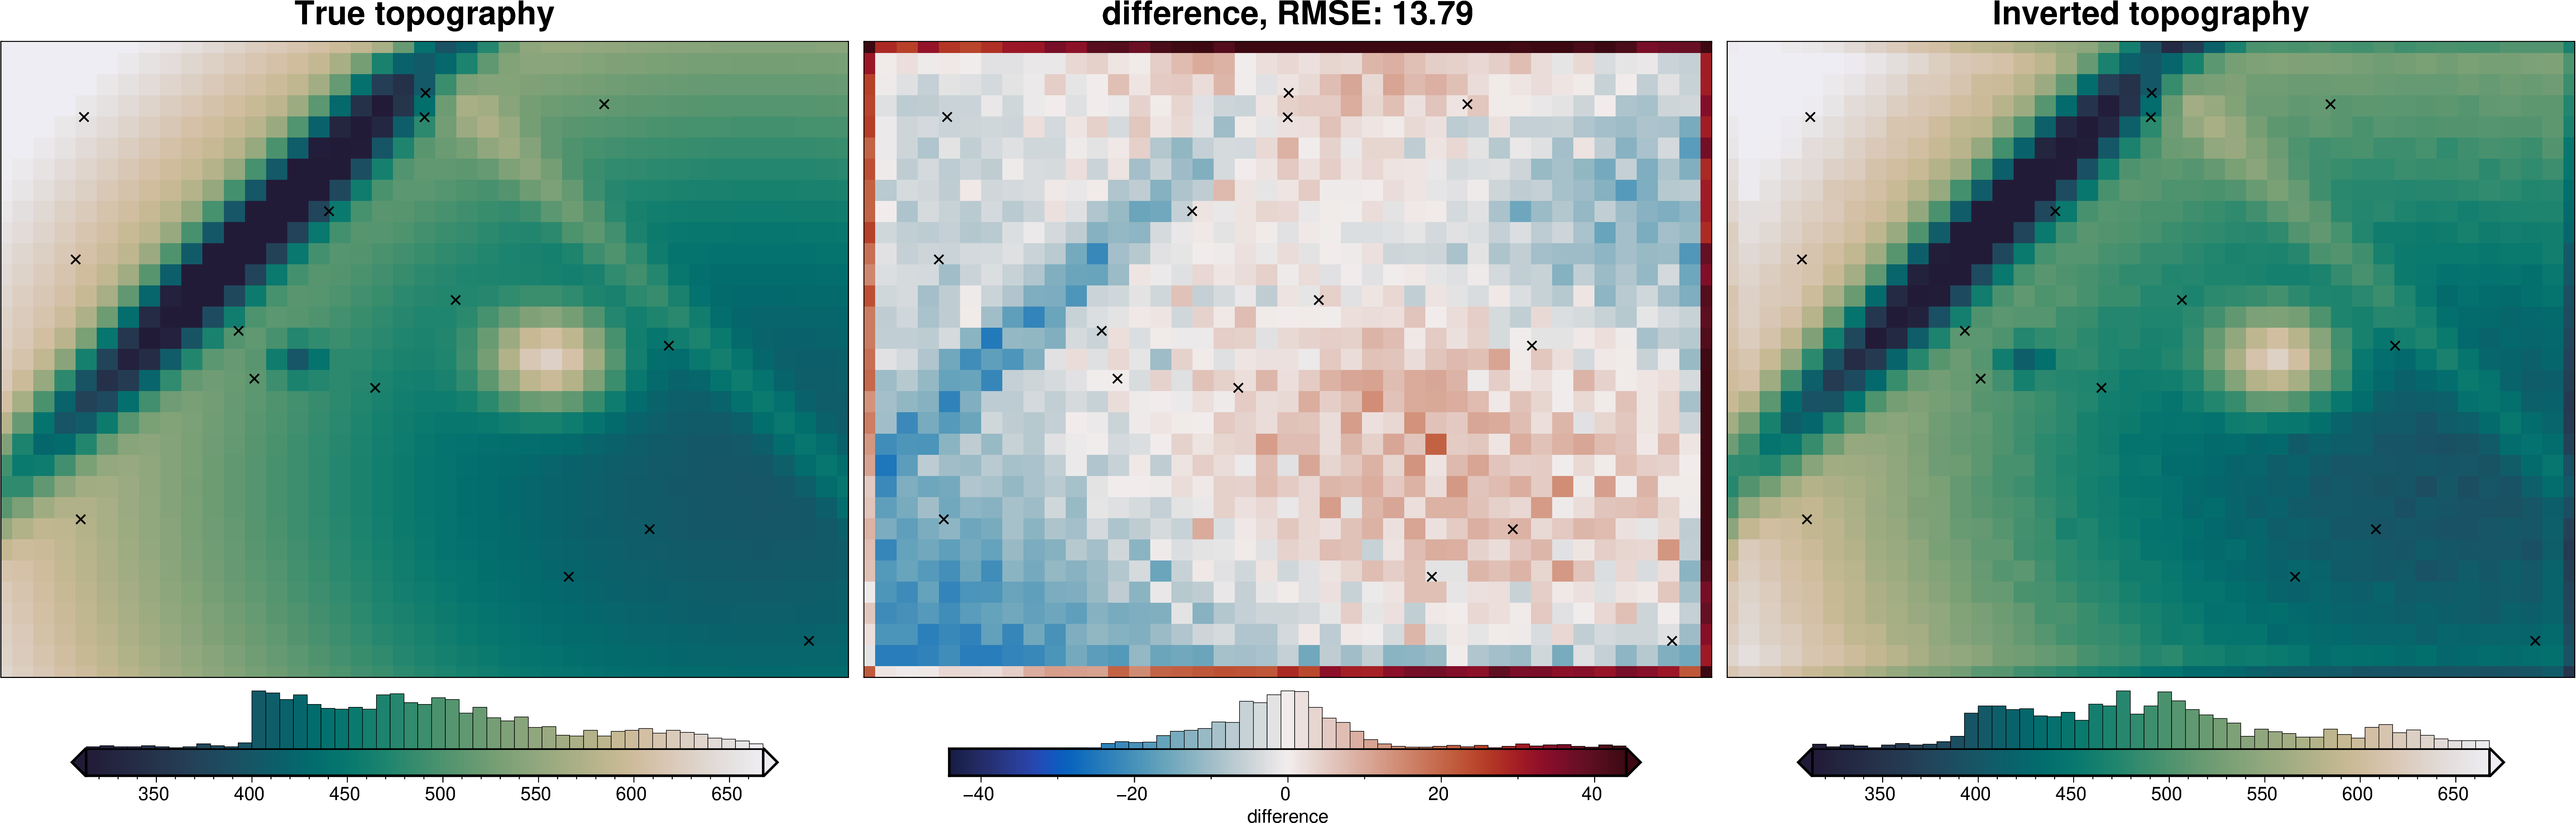

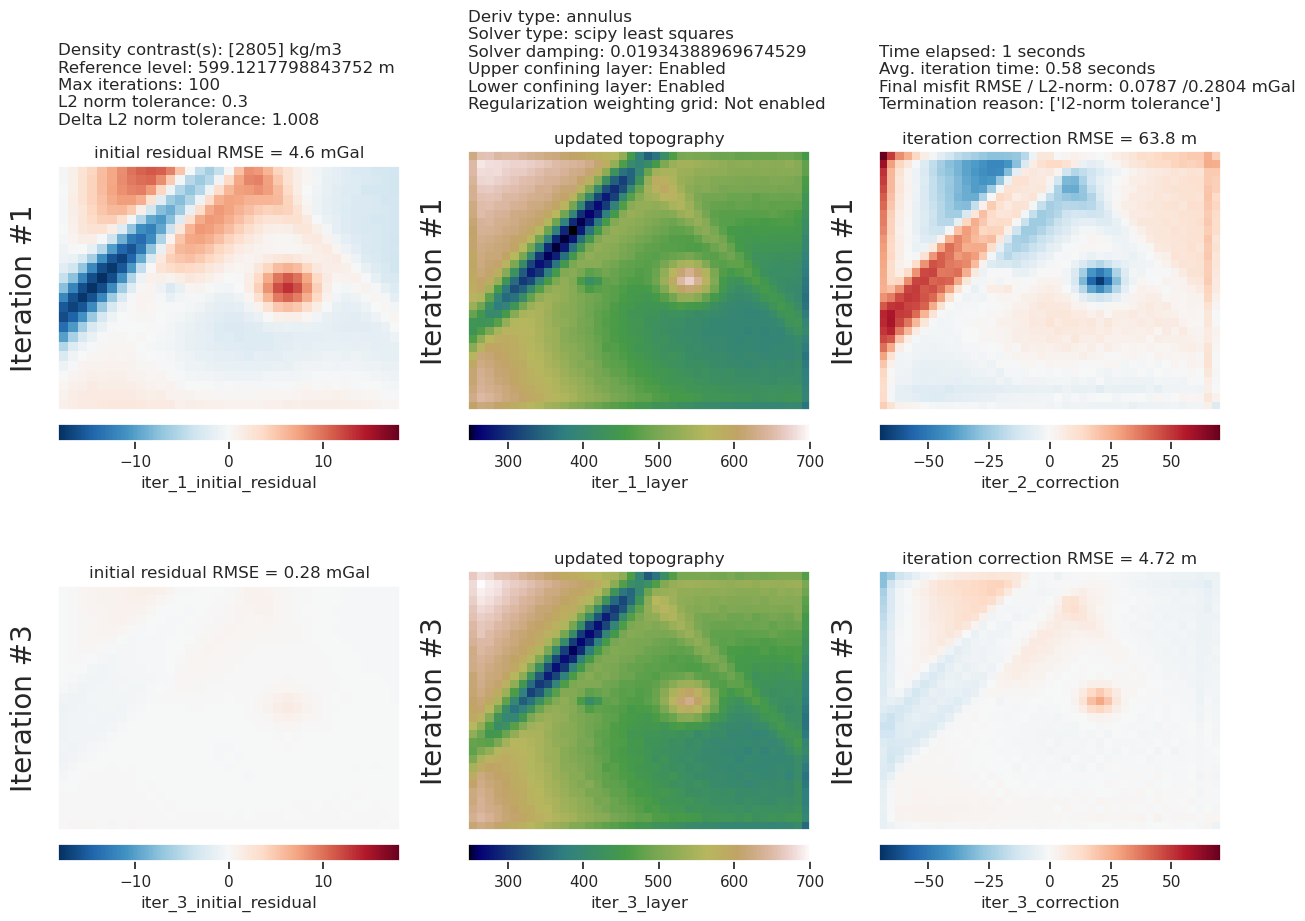

In [36]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)